In [1]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

# Robust path finding for data.mat
current_path = Path.cwd()
possible_data_paths = [
    current_path / 'data' / 'data.mat',
    current_path.parent / 'data' / 'data.mat',
    current_path.parent.parent / 'data' / 'data.mat',
    # Fallback absolute path
    Path('/home/luky/skola/KalmanNet-for-state-estimation/data/data.mat')
]

dataset_path = None
for p in possible_data_paths:
    if p.exists():
        dataset_path = p
        break

if dataset_path is None or not dataset_path.exists():
    print("Warning: data.mat not found automatically.")
    dataset_path = Path('data/data.mat')

print(f"Dataset path: {dataset_path}")

# Add project root to sys.path (2 levels up from debug/test)
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Project root added: {project_root}")

mat_data = loadmat(dataset_path)
print(mat_data.keys())


Dataset path: c:\Users\PC1\Desktop\Diplomka\KalmanNet\data\data.mat
Project root added: c:\Users\PC1\Desktop\Diplomka\KalmanNet
dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])


In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [3]:
mat_data = loadmat(dataset_path)

souradniceX_mapa = mat_data['souradniceX']
souradniceY_mapa = mat_data['souradniceY']
souradniceZ_mapa = mat_data['souradniceZ']
souradniceGNSS = mat_data['souradniceGNSS'] 
x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]

print(f"Dimensions of 1D X axis: {x_axis_unique.shape}")
print(f"Dimensions of 1D Y axis: {y_axis_unique.shape}")
print(f"Dimensions of 2D elevation data Z: {souradniceZ_mapa.shape}")

terMap_interpolator = RegularGridInterpolator(
    (y_axis_unique, x_axis_unique),
    souradniceZ_mapa,
    bounds_error=False, 
    fill_value=np.nan
)

def terMap(px, py):
    # Query bilinear interpolation over the terrain map
    points_to_query = np.column_stack((py, px))
    return terMap_interpolator(points_to_query)

Dimensions of 1D X axis: (2500,)
Dimensions of 1D Y axis: (2500,)
Dimensions of 2D elevation data Z: (2500, 2500)


In [4]:
import torch
from Systems import DynamicSystemTAN

state_dim = 4
obs_dim = 3
dT = 1
q = 1

F = torch.tensor([[1.0, 0.0, dT, 0.0],
                   [0.0, 1.0, 0.0, dT],
                   [0.0, 0.0, 1.0, 0.0],
                   [0.0, 0.0, 0.0, 1.0]])

Q = q* torch.tensor([[dT**3/3, 0.0, dT**2/2, 0.0],
                   [0.0, dT**3/3, 0.0, dT**2/2],
                   [dT**2/2, 0.0, dT, 0.0],
                   [0.0, dT**2/2, 0.0, dT]])
R = torch.tensor([[3.0**2, 0.0, 0.0],
                   [0.0, 1.0**2, 0.0],
                   [0.0, 0.0, 1.0**2]])

initial_velocity_np = souradniceGNSS[:2, 1] - souradniceGNSS[:2, 0]
# initial_velocity_np = torch.from_numpy()
initial_velocity = torch.from_numpy(np.array([0,0]))

initial_position = torch.from_numpy(souradniceGNSS[:2, 0])
x_0 = torch.cat([
    initial_position,
    initial_velocity
]).float()
print(x_0)

P_0 = torch.tensor([[25.0, 0.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0, 0.0],
                    [0.0, 0.0, 0.5, 0.0],
                    [0.0, 0.0, 0.0, 0.5]])
import torch.nn.functional as func

def h_nl_differentiable(x: torch.Tensor, map_tensor, x_min, x_max, y_min, y_max) -> torch.Tensor:
    batch_size = x.shape[0]

    px = x[:, 0]
    py = x[:, 1]

    px_norm = 2.0 * (px - x_min) / (x_max - x_min) - 1.0
    py_norm = 2.0 * (py - y_min) / (y_max - y_min) - 1.0

    sampling_grid = torch.stack((px_norm, py_norm), dim=1).view(batch_size, 1, 1, 2)

    vyska_terenu_batch = func.grid_sample(
        map_tensor.expand(batch_size, -1, -1, -1),
        sampling_grid, 
        mode='bilinear', 
        padding_mode='border',
        align_corners=True
    )

    vyska_terenu = vyska_terenu_batch.view(batch_size)

    eps = 1e-12
    vx_w, vy_w = x[:, 2], x[:, 3]
    norm_v_w = torch.sqrt(vx_w**2 + vy_w**2).clamp(min=eps)
    cos_psi = vx_w / norm_v_w
    sin_psi = vy_w / norm_v_w

    vx_b = cos_psi * vx_w - sin_psi * vy_w 
    vy_b = sin_psi * vx_w + cos_psi * vy_w

    result = torch.stack([vyska_terenu, vx_b, vy_b], dim=1)

    return result

x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]
terMap_tensor = torch.from_numpy(souradniceZ_mapa).float().unsqueeze(0).unsqueeze(0).to(device)
x_min, x_max = x_axis_unique.min(), x_axis_unique.max()
y_min, y_max = y_axis_unique.min(), y_axis_unique.max()

h_wrapper = lambda x: h_nl_differentiable(
    x, 
    map_tensor=terMap_tensor, 
    x_min=x_min, 
    x_max=x_max, 
    y_min=y_min, 
    y_max=y_max
)

system_model = DynamicSystemTAN(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q.float(),
    R=R.float(),
    Ex0=x_0.float(),
    P0=P_0.float(),
    F=F.float(),
    h=h_wrapper,
    x_axis_unique=x_axis_unique, 
    y_axis_unique=y_axis_unique,
    device=device
)

tensor([1487547.1250, 6395520.5000,       0.0000,       0.0000])
INFO: DynamicSystemTAN inicializován s hranicemi mapy:
  X: [1476611.42, 1489541.47]
  Y: [6384032.63, 6400441.34]


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from utils import utils
import torch
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
from copy import deepcopy
from state_NN_models import TAN
from utils import trainer 

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import os
from utils import trainer # Předpokládám, že toto máš

# === 1. ZJEDNODUŠENÝ DATA MANAGER (BEZ NORMALIZACE) ===
class NavigationDataManager:
    def __init__(self, data_dir):
        """
        Jen držák na cestu k datům. Žádná statistika, žádná normalizace.
        """
        self.data_dir = data_dir
        
    def get_dataloader(self, seq_len, split='train', shuffle=True, batch_size=32):
        # Sestavení cesty: ./generated_data/len_100/train.pt
        path = os.path.join(self.data_dir, f'len_{seq_len}', f'{split}.pt')
        
        if not os.path.exists(path):
            raise FileNotFoundError(f"❌ Dataset nenalezen: {path}")
            
        # Načtení tenzorů
        data = torch.load(path)
        x = data['x'] # Stav [Batch, Seq, DimX]
        y = data['y'] # Měření [Batch, Seq, DimY] - RAW DATA
        
        # Vytvoření datasetu
        dataset = TensorDataset(x, y)
        
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# === 2. KONFIGURACE CURRICULA ===
DATA_DIR = './generated_data_clean_motion'

# Inicializace manažera (teď je to jen wrapper pro načítání souborů)
data_manager = NavigationDataManager(DATA_DIR)

# Definice fází (zde řídíš, jak se trénink vyvíjí)
curriculum_schedule = [
    # FÁZE 1: Warm-up (Krátké sekvence)
    {
        'phase_id': 1,
        'seq_len': 10,          
        'epochs': 500,           
        'lr': 1e-3, 
        'batch_size': 256
    },
    
    # FÁZE 2: Stabilizace (Střední délka)
    {
        'phase_id': 2,
        'seq_len': 100, 
        'epochs': 200, 
        'lr': 1e-4,             
        'batch_size': 128
    },
    
    # FÁZE 3: Long-term Reality (Plná délka)
    {
        'phase_id': 3,
        'seq_len': 300,         
        'epochs': 200, 
        'lr': 5e-5,             
        'batch_size': 64       # Menší batch kvůli paměti GPU u dlouhých sekvencí
    }
]

# === 3. NAČÍTÁNÍ DO PAMĚTI (CACHING) ===
print("\n=== NAČÍTÁNÍ RAW DAT Z DISKU (BEZ EXT. NORMALIZACE) ===")
datasets_cache = {} 

for phase in curriculum_schedule:
    seq_len = phase['seq_len']
    bs = phase['batch_size']
    
    print(f"📥 Načítám Fázi {phase['phase_id']}: Seq={seq_len} | Batch={bs} ...")
    
    try:
        # Použití DataManageru
        train_loader = data_manager.get_dataloader(seq_len=seq_len, split='train', shuffle=True, batch_size=bs)
        val_loader = data_manager.get_dataloader(seq_len=seq_len, split='val', shuffle=False, batch_size=bs)
        
        # Uložení do cache
        datasets_cache[phase['phase_id']] = (train_loader, val_loader)
        
        # Rychlá kontrola pro jistotu
        x_ex, y_ex = next(iter(train_loader))
        if phase['phase_id'] == 1:
            print(f"   🔎 Ukázka RAW dat (y): {y_ex[0, 0, :].tolist()}") 
            # Měl bys vidět velká čísla (např. 250.0) a malá (0.2), ne ~0.0
        
    except FileNotFoundError as e:
        print(f"   ⚠️ CHYBA: {e}")
        # raise e # Odkomentuj, pokud chceš, aby to spadlo při chybě

print("\n✅ Data připravena. Normalizaci řeší model.")


=== NAČÍTÁNÍ RAW DAT Z DISKU (BEZ EXT. NORMALIZACE) ===
📥 Načítám Fázi 1: Seq=10 | Batch=256 ...
   🔎 Ukázka RAW dat (y): [362.96917724609375, -12.126676559448242, 0.16327548027038574]
📥 Načítám Fázi 2: Seq=100 | Batch=128 ...
📥 Načítám Fázi 3: Seq=300 | Batch=64 ...

✅ Data připravena. Normalizaci řeší model.


In [7]:
# --- A) KONFIGURACE SÍTĚ ---
# for most consistent:
# state_knet2 = TAN.StateKalmanNetTAN(
#         system_model=system_model, 
#         device=device,
#         hidden_size_multiplier=10,       
#         output_layer_multiplier=4,
#         num_gru_layers=1,
#         gru_hidden_dim_multiplier=6      
# ).to(device)

# for most consistent and accurate most_consistent_and_accurate_knet:
state_knet2 = TAN.StateKalmanNetTAN(
        system_model=system_model, 
        device=device,
        hidden_size_multiplier=12,       
        output_layer_multiplier=4,
        num_gru_layers=1,
        gru_hidden_dim_multiplier=8      
).to(device)


print(state_knet2)

DEBUG: Layer 'output_final_linear.0' initialized near zero (Start K=0).
StateKalmanNetTAN(
  (dnn): DNN_KalmanNetTAN(
    (input_layer): Sequential(
      (0): Linear(in_features=14, out_features=672, bias=True)
      (1): ReLU()
    )
    (gru): GRU(672, 200)
    (output_hidden_layer): Sequential(
      (0): Linear(in_features=200, out_features=48, bias=True)
      (1): ReLU()
    )
    (output_final_linear): Sequential(
      (0): Linear(in_features=48, out_features=12, bias=True)
    )
  )
)


In [8]:
import os
import torch

# ==========================================
# 1. NASTAVENÍ NÁZVŮ SOUBORŮ (Manuální vstup)
# ==========================================
# Složka, kde jsou váhy uloženy
WEIGHTS_DIR = 'weights'

# Zde doplň přesné názvy souborů .pth
# KNET_FILENAME = 'best_Knet_test_results.pth'                                          # Příklad
KNET_FILENAME = 'most_consistent_and_accurate_knet.pth'

# ==========================================
# 2. FUNKCE PRO BEZPEČNÉ NAČTENÍ
# ==========================================
def load_pretrained_weights(model, filename, model_name):
    filepath = os.path.join(WEIGHTS_DIR, filename)
    
    if not os.path.exists(filepath):
        print(f"⚠️  VAROVÁNÍ: Soubor '{filename}' pro {model_name} nebyl nalezen v '{WEIGHTS_DIR}'.")
        return

    try:
        # Načtení na správné zařízení (CPU/GPU)
        checkpoint = torch.load(filepath, map_location=device)
        
        # Detekce, zda jde o čistý state_dict nebo slovník checkpointu
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            # Pokud je to checkpoint z traineru, vytáhneme jen váhy modelu
            state_dict = checkpoint['model_state_dict']
        elif isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            # Předpokládáme, že je to přímo state_dict
            state_dict = checkpoint

        # Nahrání vah do modelu
        model.load_state_dict(state_dict)
        
        # Důležité: Přepnutí do evaluačního módu (vypne Dropout, fixuje BatchNorm)
        model.eval()
        
        print(f"✅ {model_name}: Váhy úspěšně načteny z '{filename}'.")
        
    except Exception as e:
        print(f"❌ CHYBA: Nepodařilo se načíst váhy pro {model_name}.\n   Důvod: {e}")

# ==========================================
# 3. SPUŠTĚNÍ NAČÍTÁNÍ
# ==========================================
print(f"--- Načítání vah ze složky: {os.path.abspath(WEIGHTS_DIR)} ---\n")

# Načtení State KalmanNet
load_pretrained_weights(state_knet2, KNET_FILENAME, "State KalmanNet")

--- Načítání vah ze složky: c:\Users\PC1\Desktop\Diplomka\KalmanNet\TAN\real_trajectory\weights ---

✅ State KalmanNet: Váhy úspěšně načteny z 'most_consistent_and_accurate_knet.pth'.


In [9]:
if False:
    # save model.
    save_path = f'most_consistent_knet.pth'
    torch.save(state_knet2.state_dict(), save_path)
    print(f"Model saved to '{save_path}'.")

# Test na realne trajektorii

=== SPUŠTĚNÍ MONTE CARLO SIMULACE (50 běhů) ===
Modely: KalmanNet vs. UKF vs. PF


Simulace:   0%|          | 0/50 [00:00<?, ?it/s]

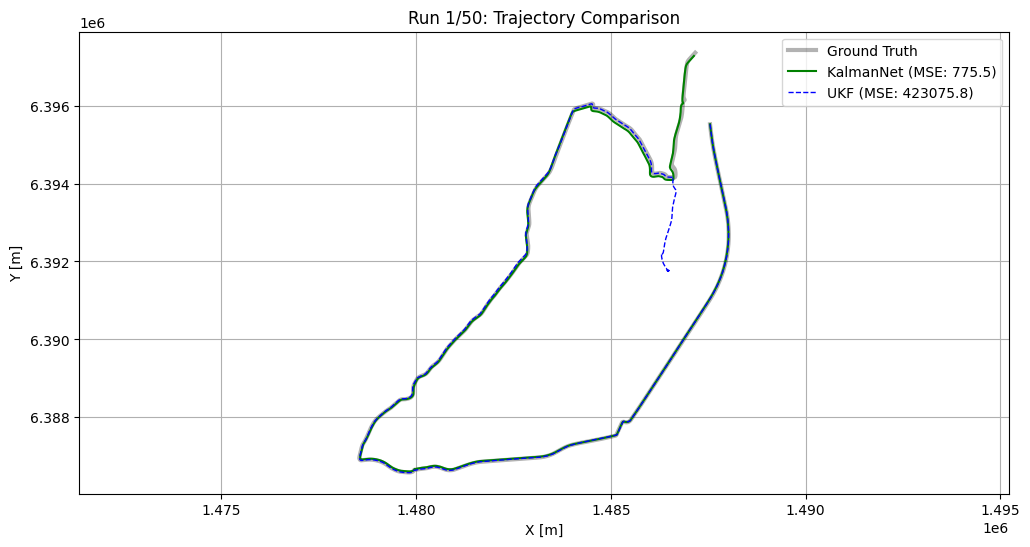

Simulace:   2%|▏         | 1/50 [00:07<05:58,  7.32s/it]

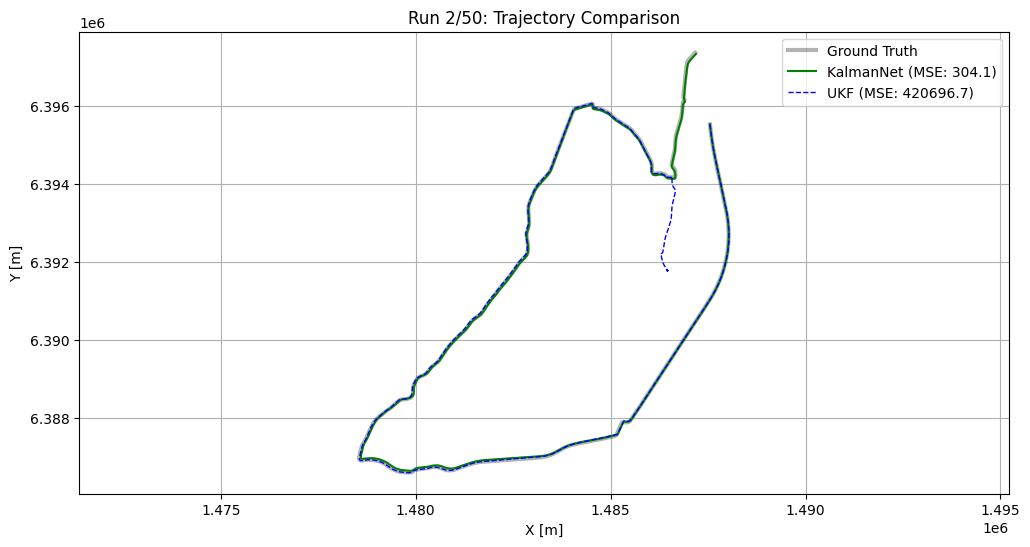

Simulace:   4%|▍         | 2/50 [00:14<05:55,  7.40s/it]

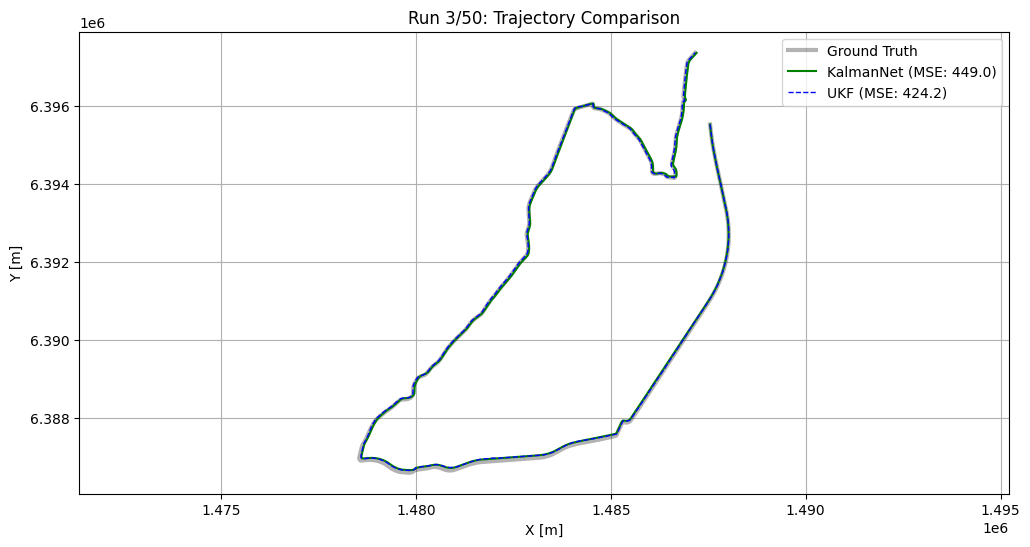

Simulace:   6%|▌         | 3/50 [00:22<05:48,  7.41s/it]

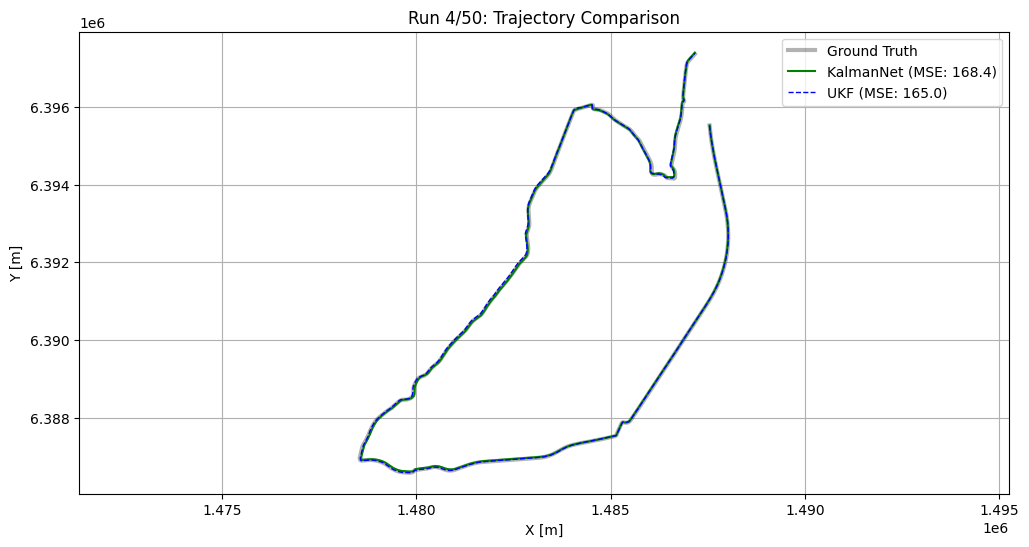

Simulace:   8%|▊         | 4/50 [00:29<05:30,  7.18s/it]

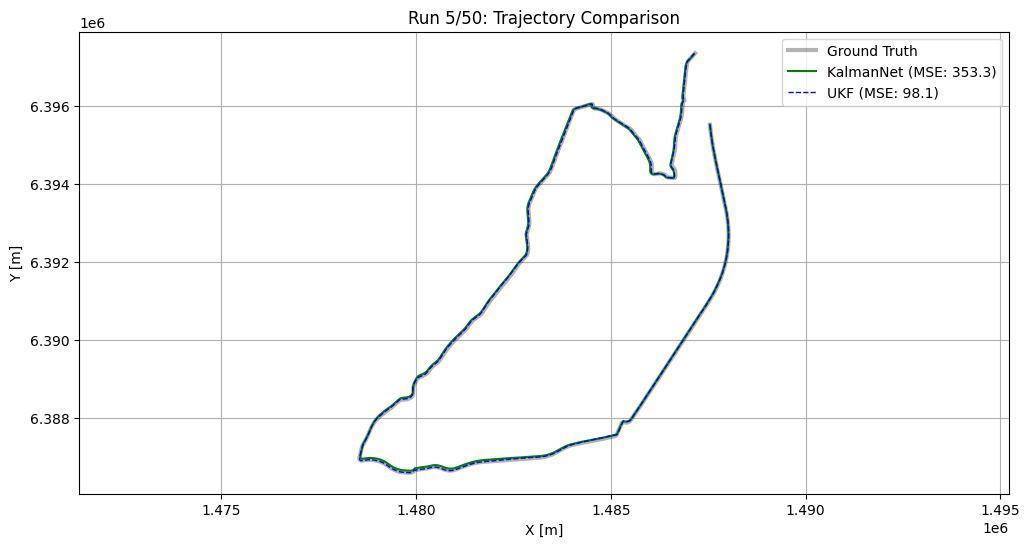

Simulace:  10%|█         | 5/50 [00:35<05:14,  6.98s/it]

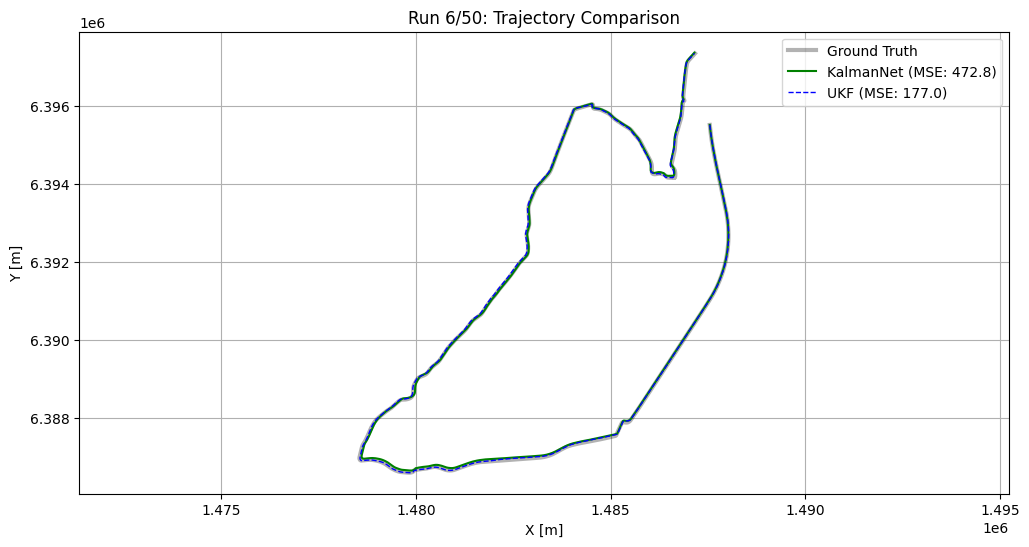

Simulace:  12%|█▏        | 6/50 [00:42<05:02,  6.87s/it]

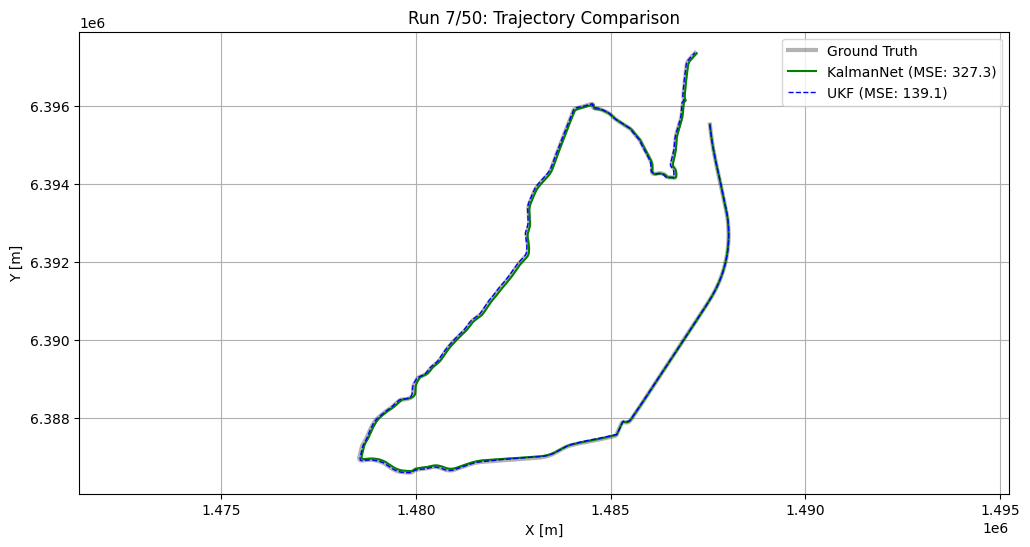

Simulace:  14%|█▍        | 7/50 [00:48<04:51,  6.77s/it]

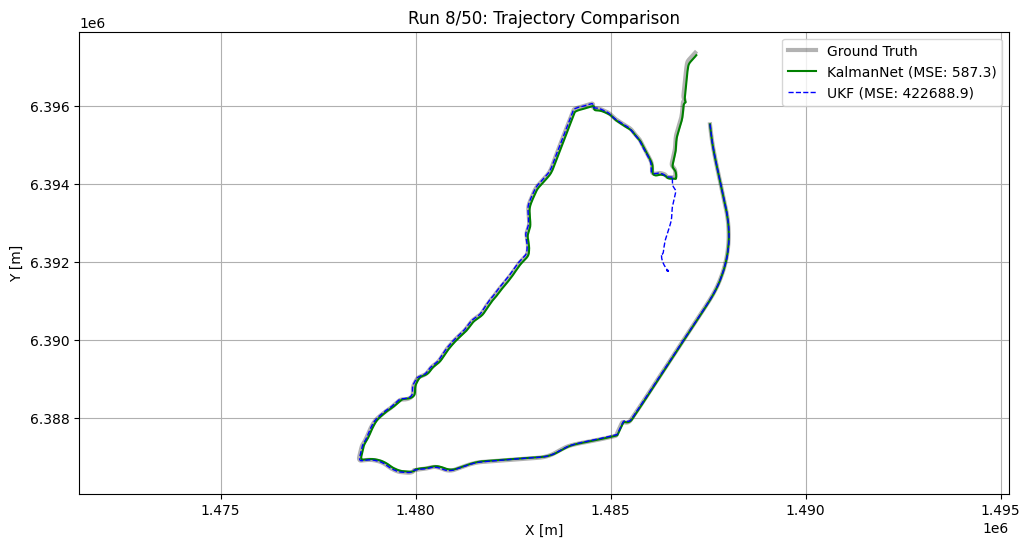

Simulace:  16%|█▌        | 8/50 [00:55<04:46,  6.83s/it]

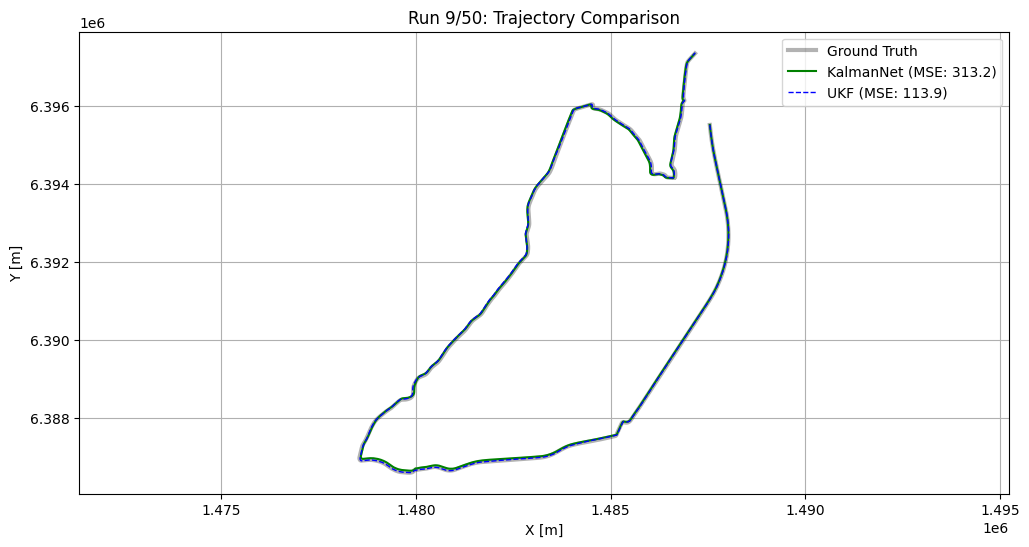

Simulace:  18%|█▊        | 9/50 [01:03<04:50,  7.10s/it]

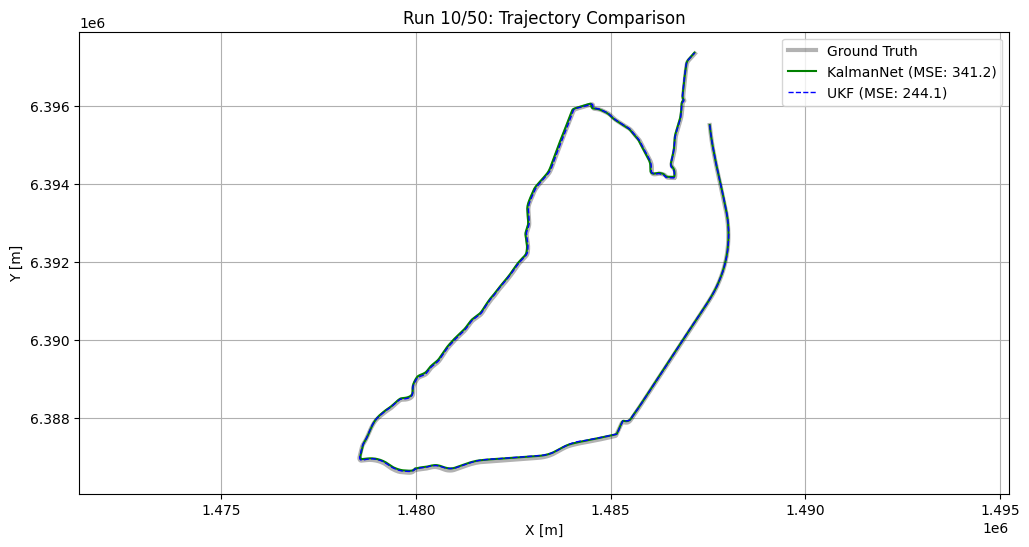

Simulace:  20%|██        | 10/50 [01:11<04:49,  7.23s/it]

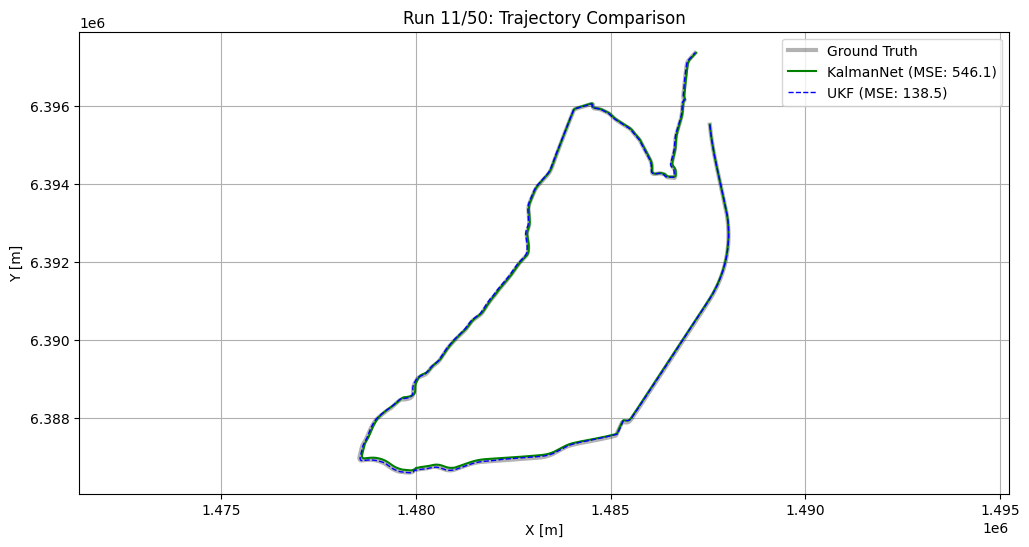

Simulace:  22%|██▏       | 11/50 [01:18<04:46,  7.35s/it]

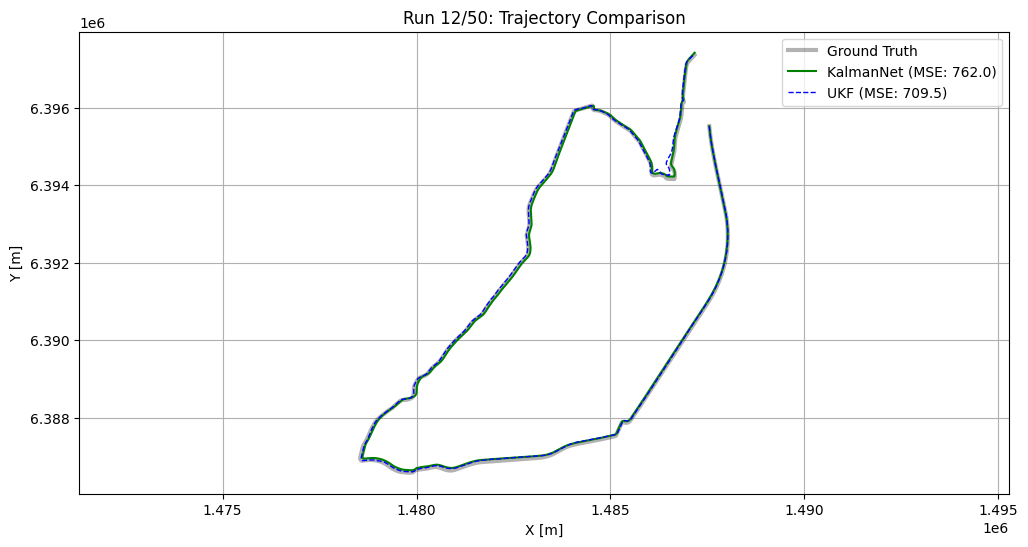

Simulace:  24%|██▍       | 12/50 [01:26<04:42,  7.44s/it]

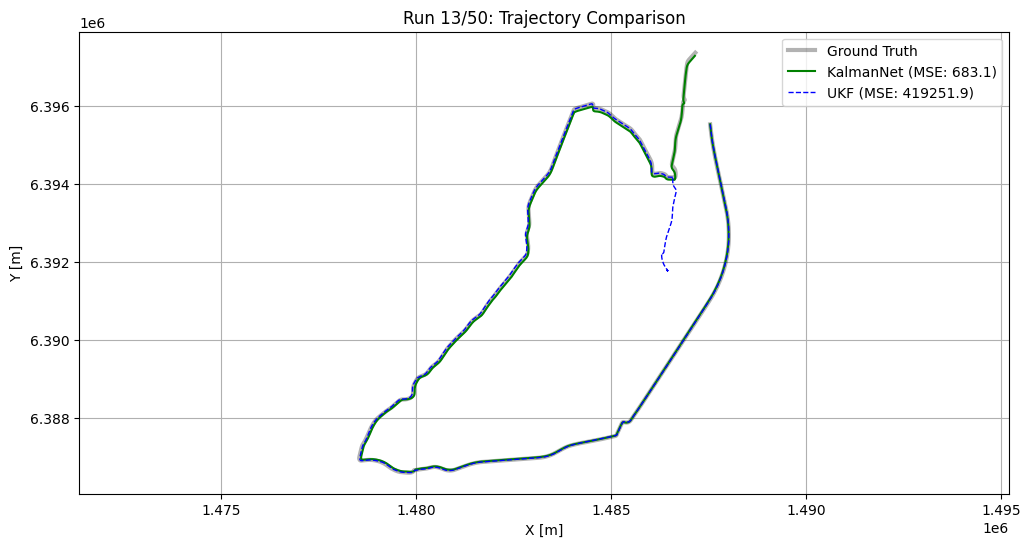

Simulace:  26%|██▌       | 13/50 [01:34<04:39,  7.55s/it]

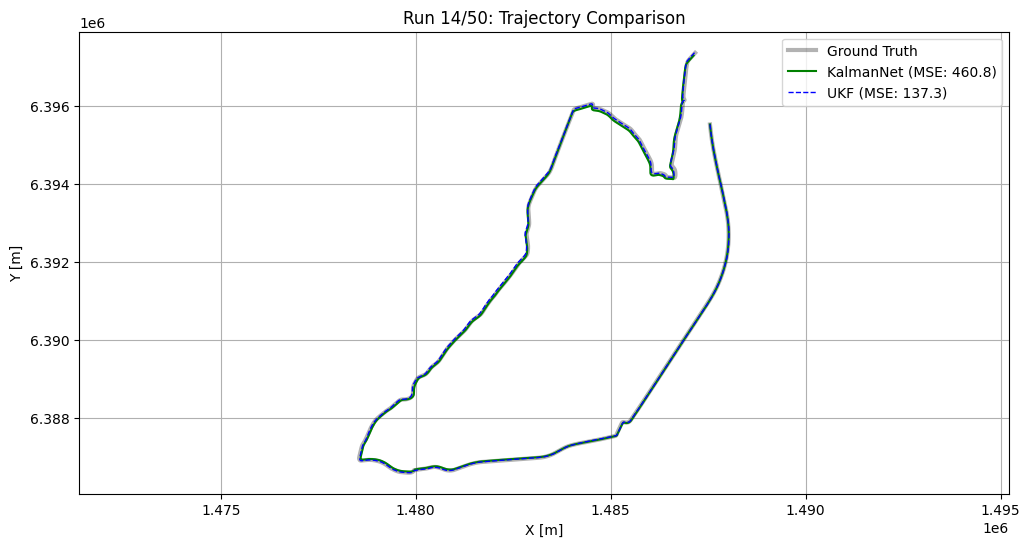

Simulace:  28%|██▊       | 14/50 [01:41<04:33,  7.59s/it]

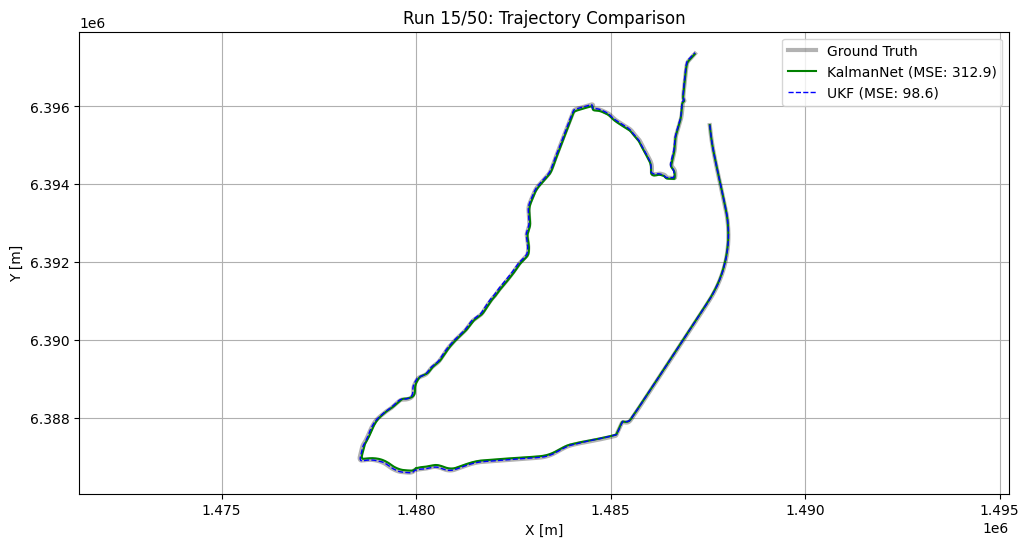

Simulace:  30%|███       | 15/50 [01:49<04:24,  7.57s/it]

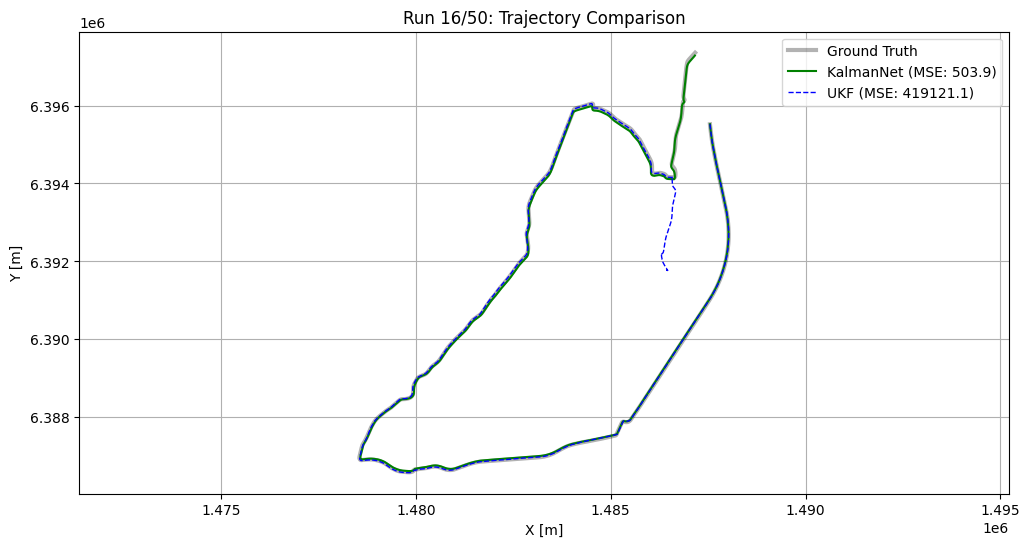

Simulace:  32%|███▏      | 16/50 [01:56<04:15,  7.52s/it]

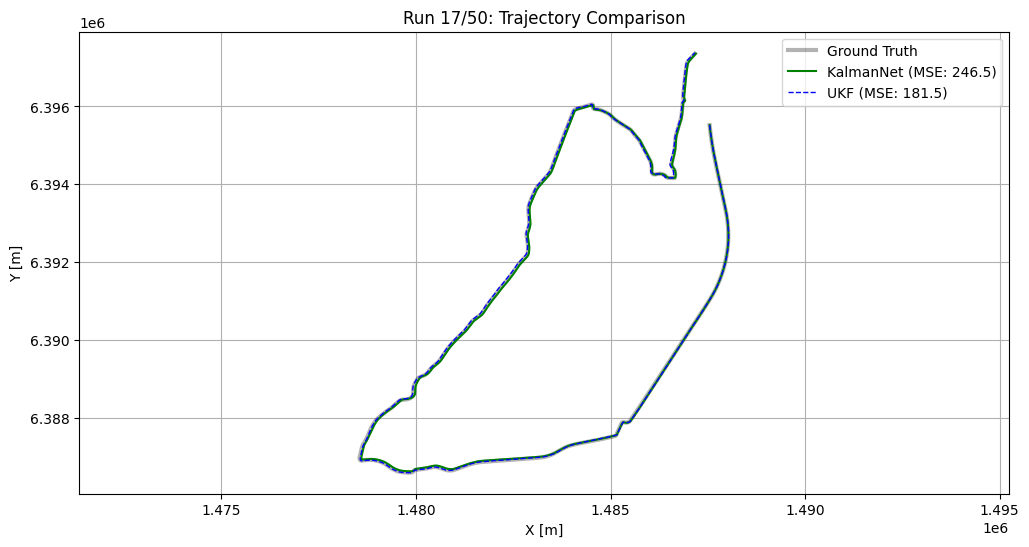

Simulace:  34%|███▍      | 17/50 [02:03<04:05,  7.45s/it]

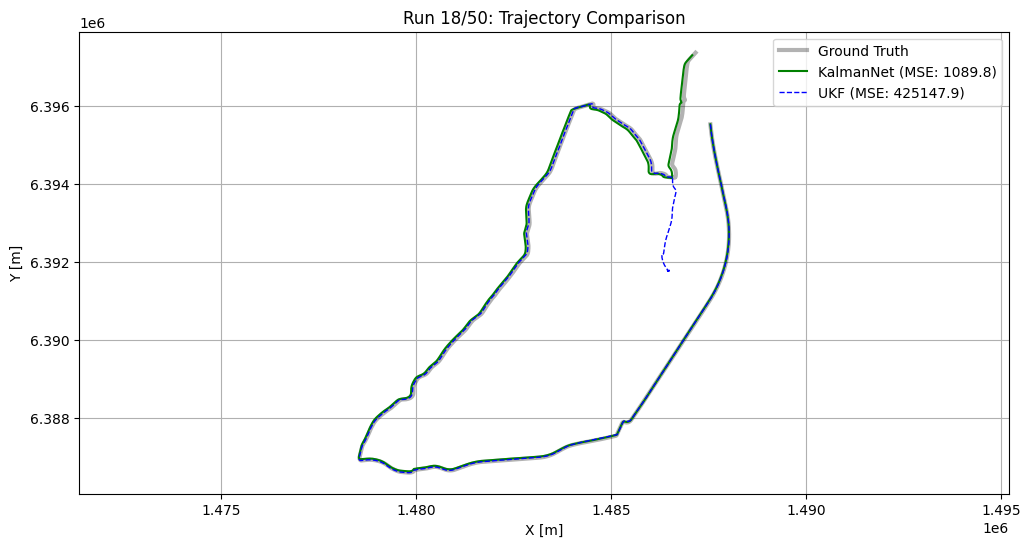

Simulace:  36%|███▌      | 18/50 [02:11<03:58,  7.46s/it]

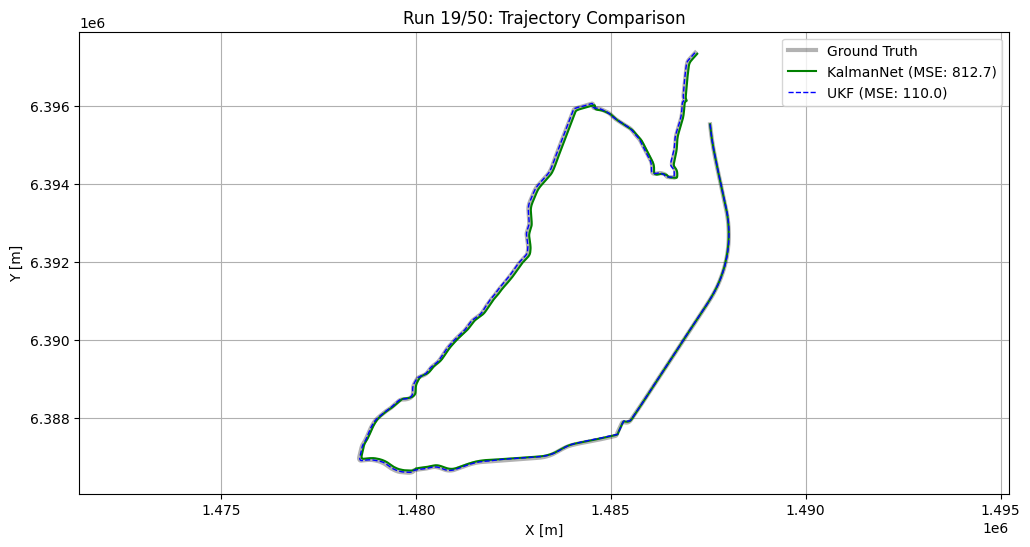

Simulace:  38%|███▊      | 19/50 [02:18<03:50,  7.44s/it]

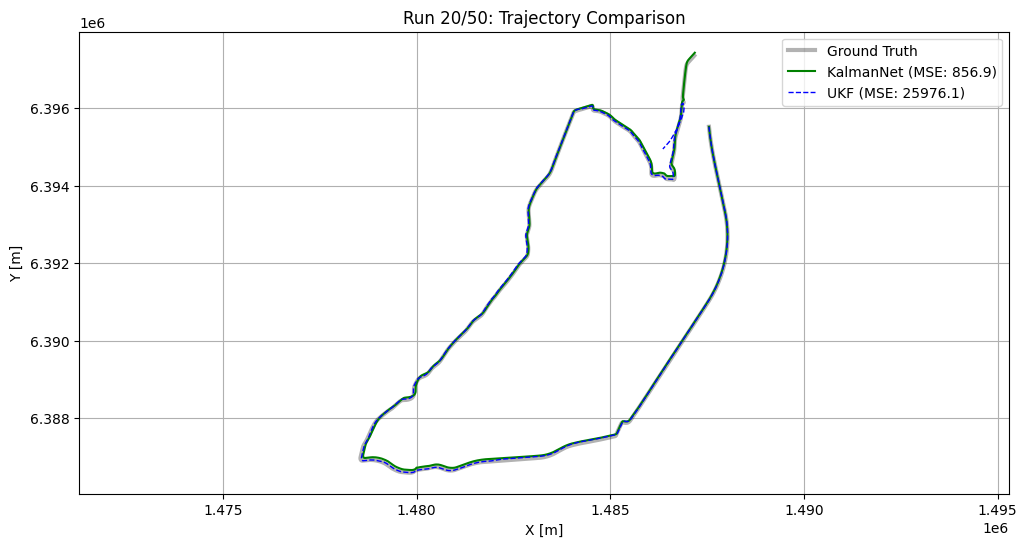

Simulace:  40%|████      | 20/50 [02:26<03:42,  7.41s/it]

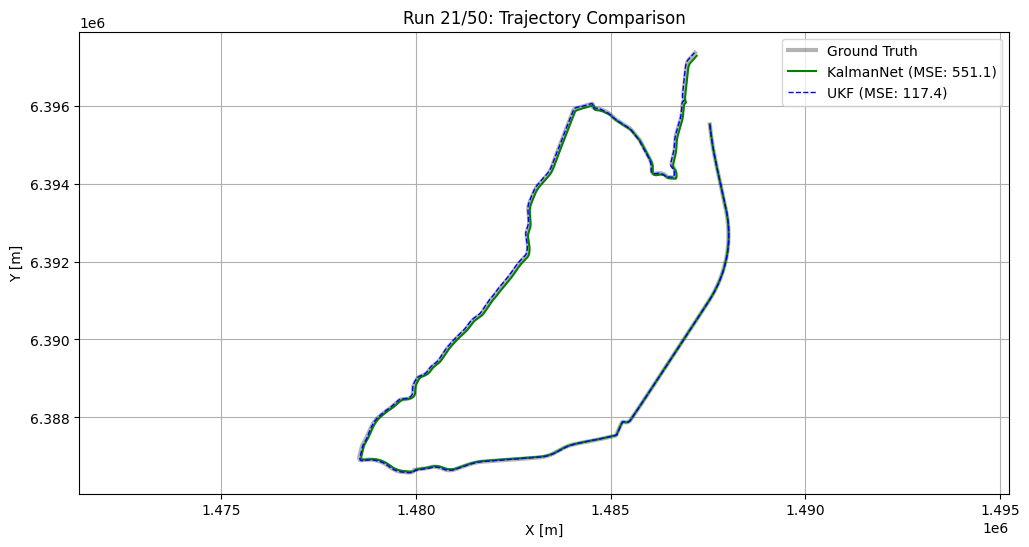

Simulace:  42%|████▏     | 21/50 [02:33<03:35,  7.45s/it]

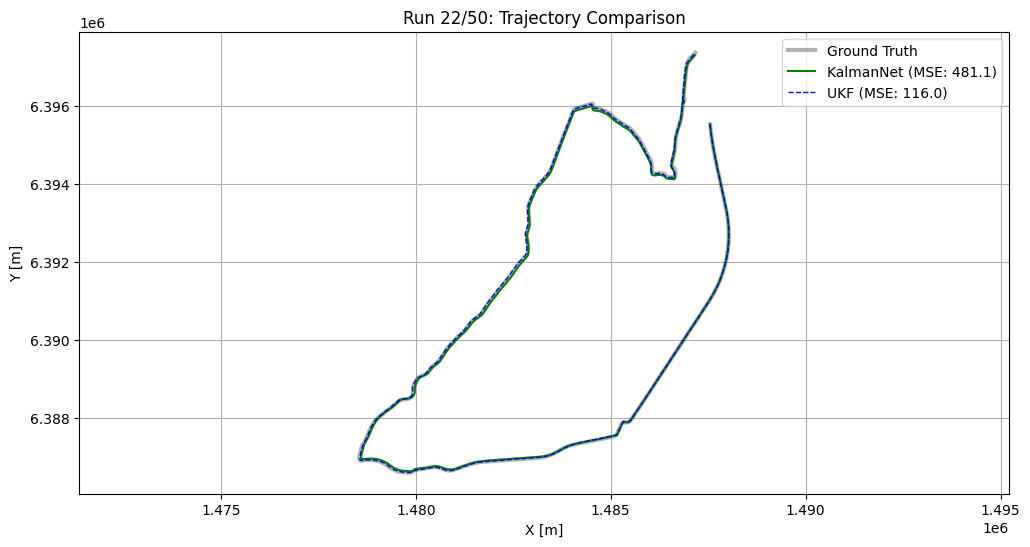

Simulace:  44%|████▍     | 22/50 [02:41<03:29,  7.47s/it]

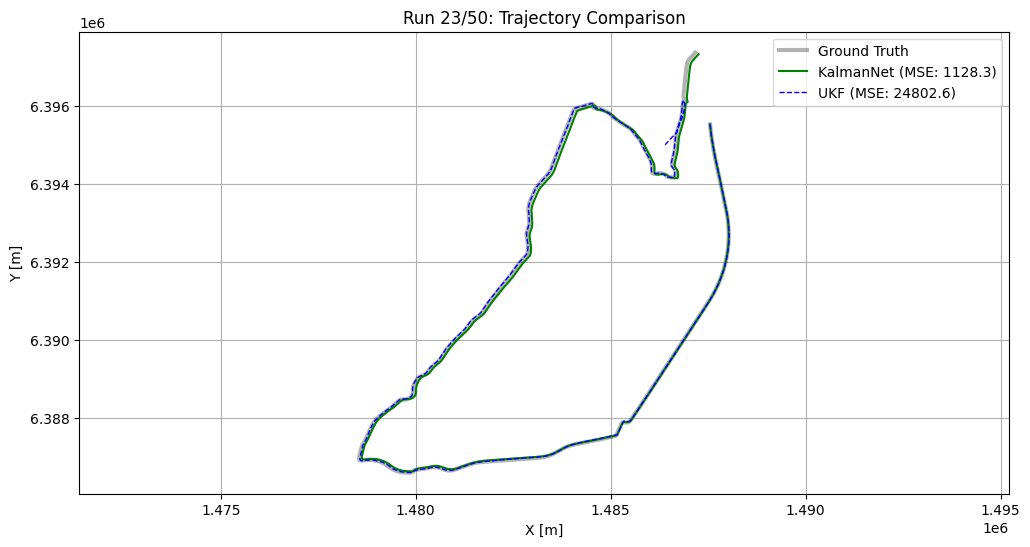

Simulace:  46%|████▌     | 23/50 [02:48<03:20,  7.41s/it]

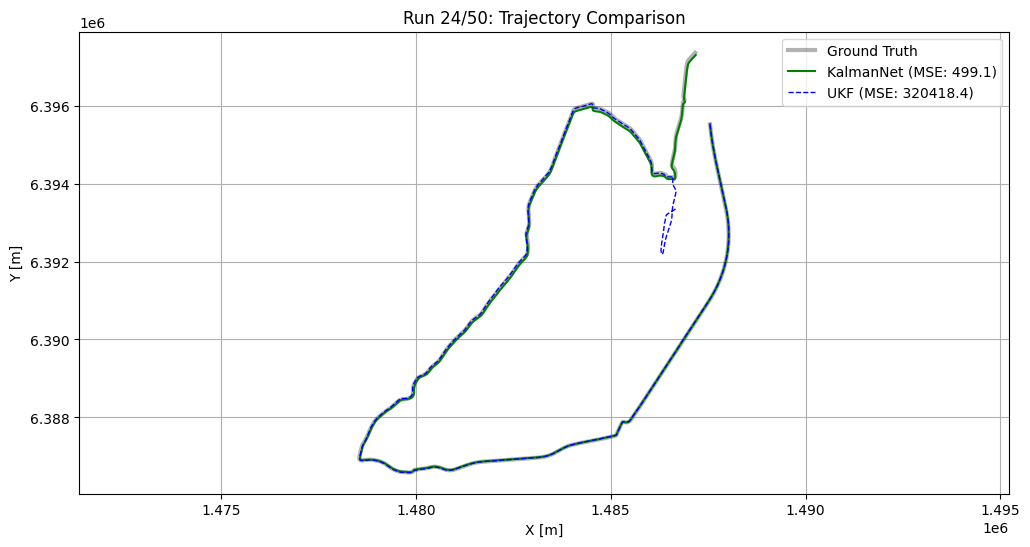

Simulace:  48%|████▊     | 24/50 [02:55<03:11,  7.38s/it]

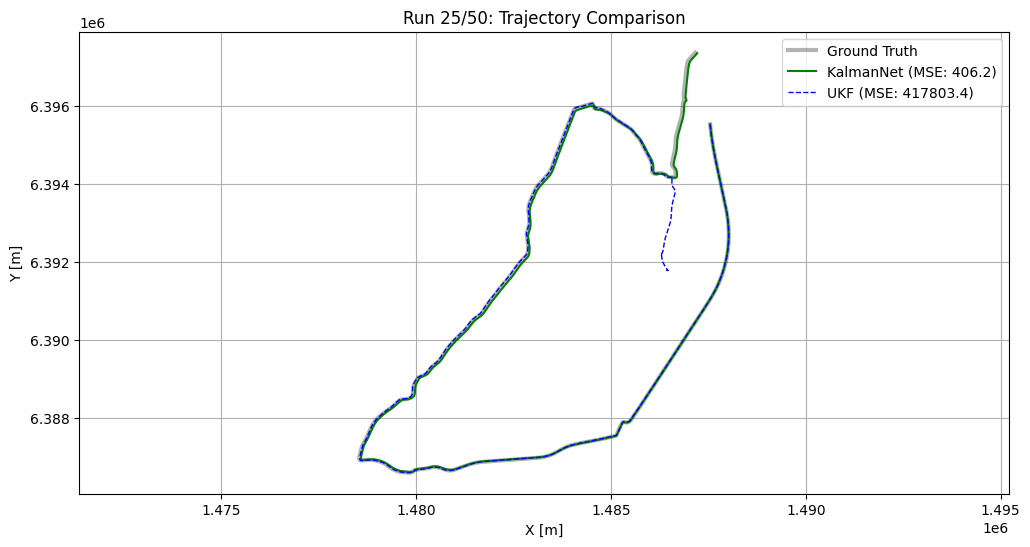

Simulace:  50%|█████     | 25/50 [03:03<03:03,  7.36s/it]

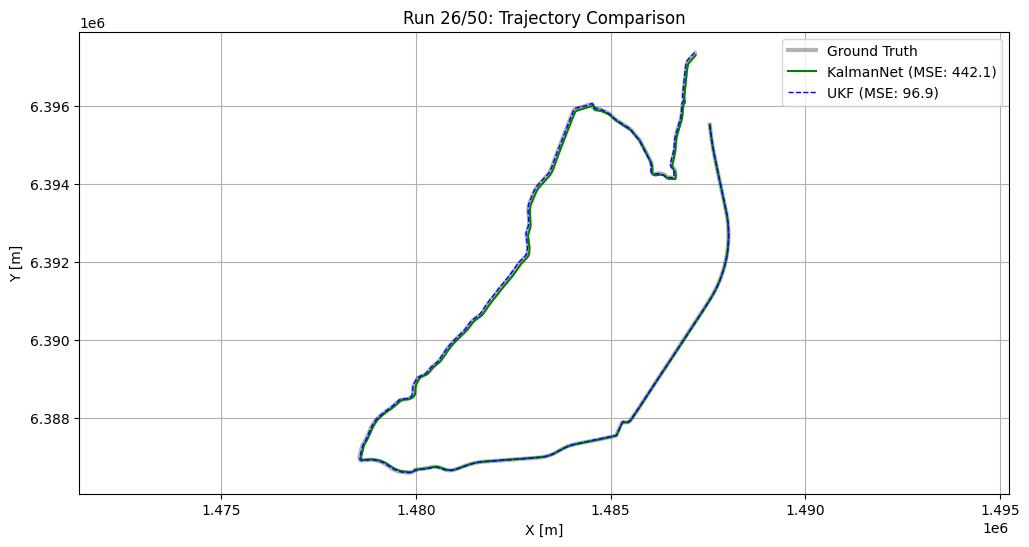

Simulace:  52%|█████▏    | 26/50 [03:10<02:57,  7.41s/it]

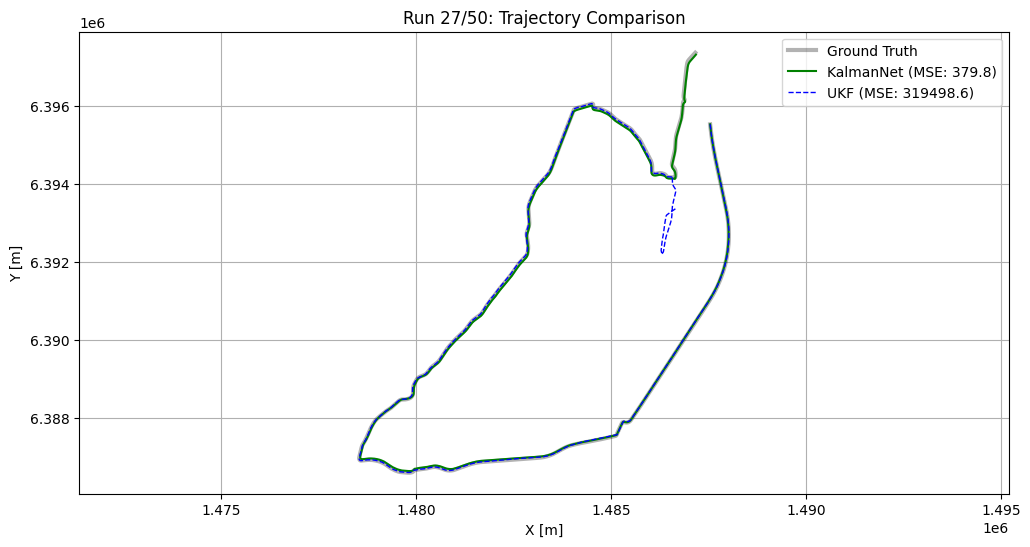

Simulace:  54%|█████▍    | 27/50 [03:18<02:52,  7.51s/it]

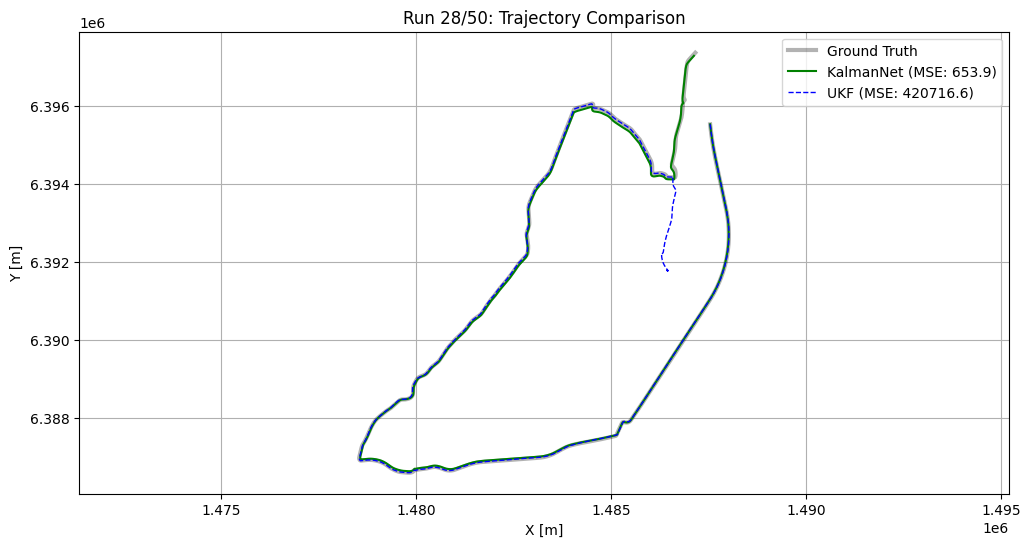

Simulace:  56%|█████▌    | 28/50 [03:26<02:46,  7.57s/it]

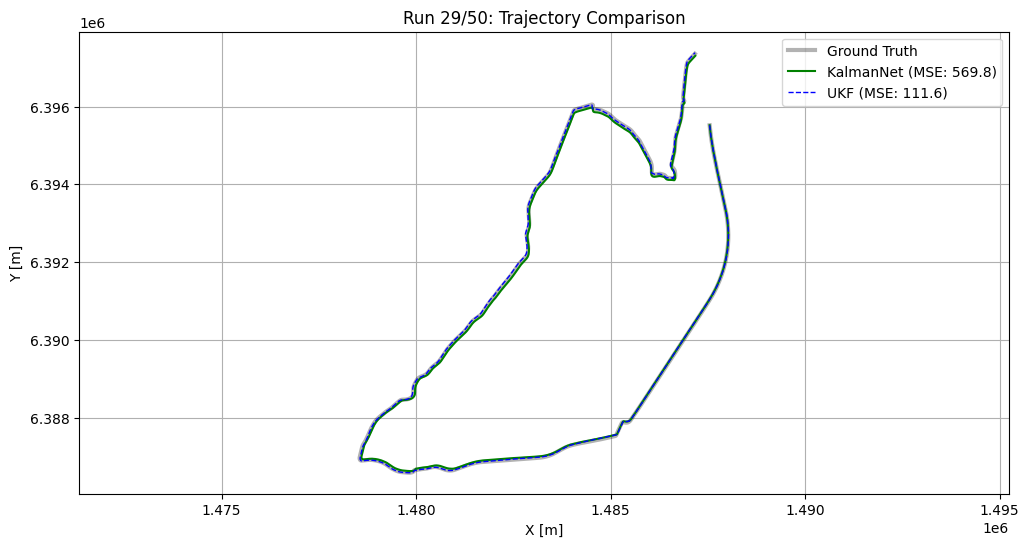

Simulace:  58%|█████▊    | 29/50 [03:33<02:39,  7.60s/it]

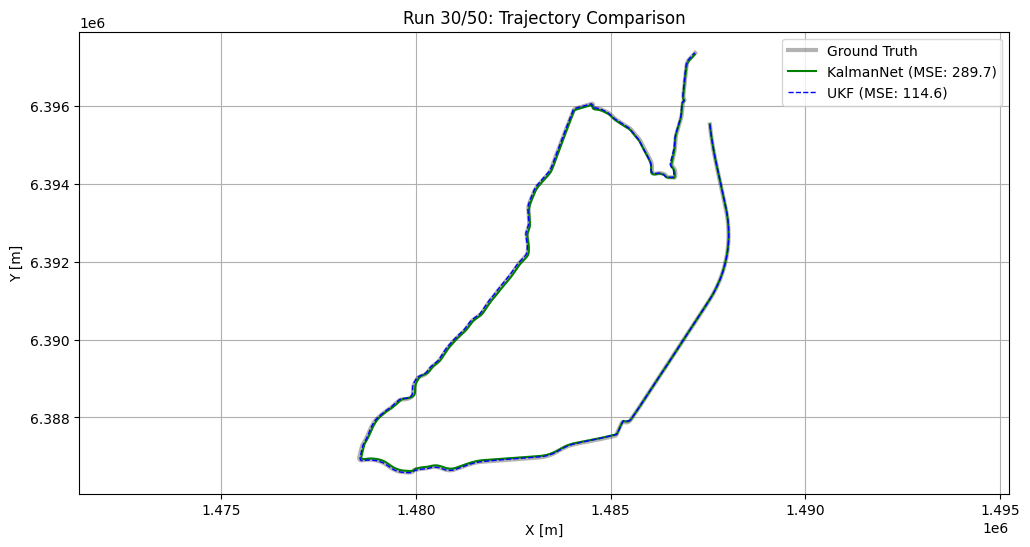

Simulace:  60%|██████    | 30/50 [03:41<02:32,  7.62s/it]

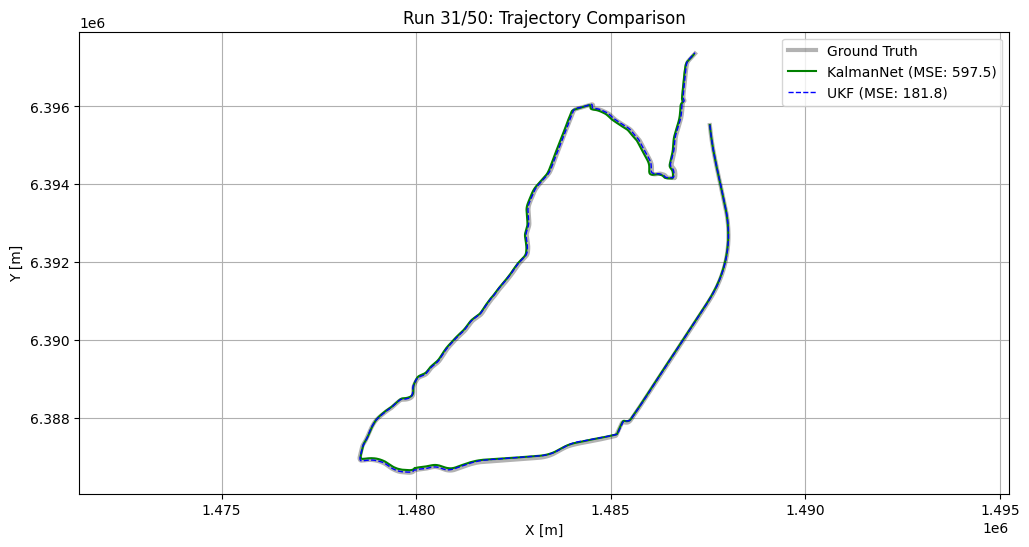

Simulace:  62%|██████▏   | 31/50 [03:48<02:23,  7.55s/it]

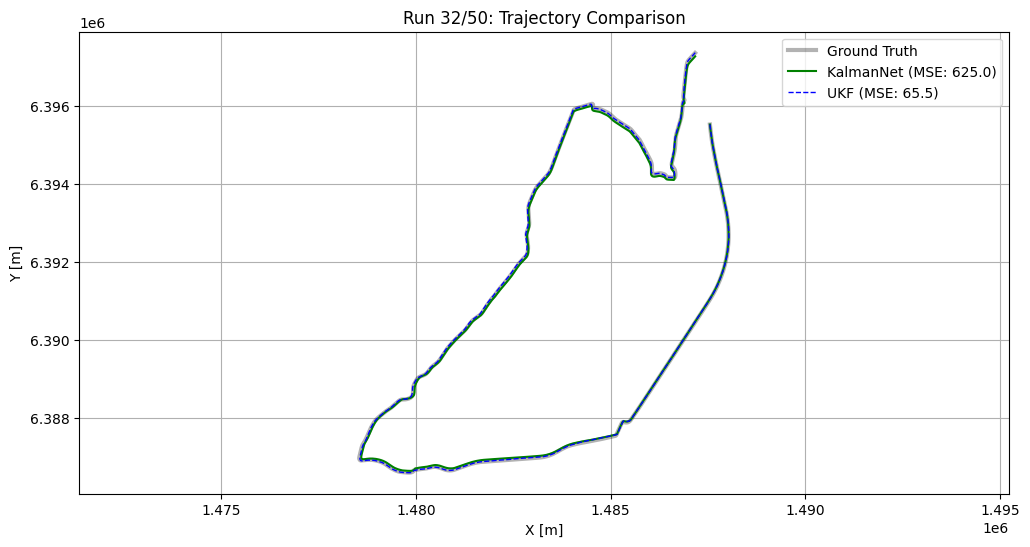

Simulace:  64%|██████▍   | 32/50 [03:56<02:15,  7.51s/it]

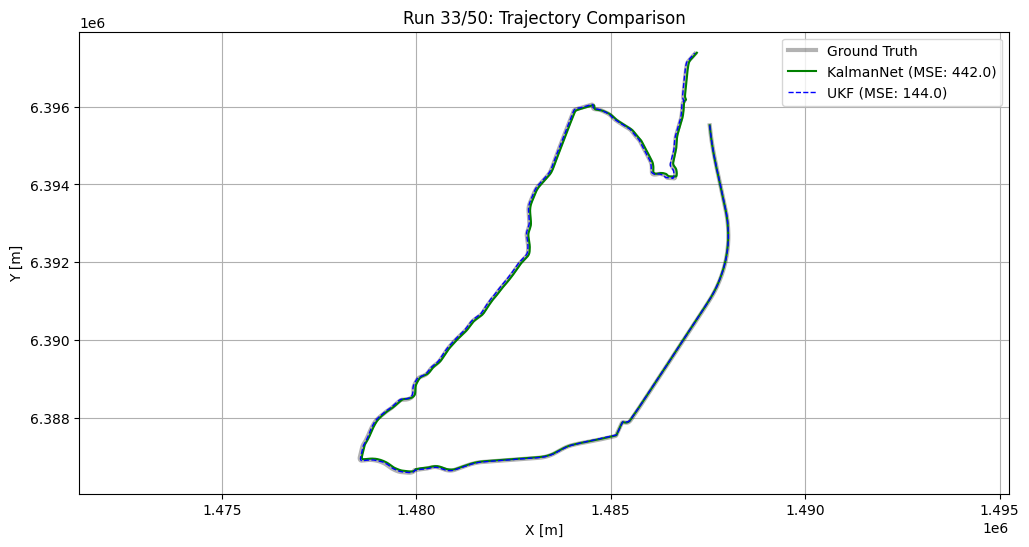

Simulace:  66%|██████▌   | 33/50 [04:03<02:07,  7.51s/it]

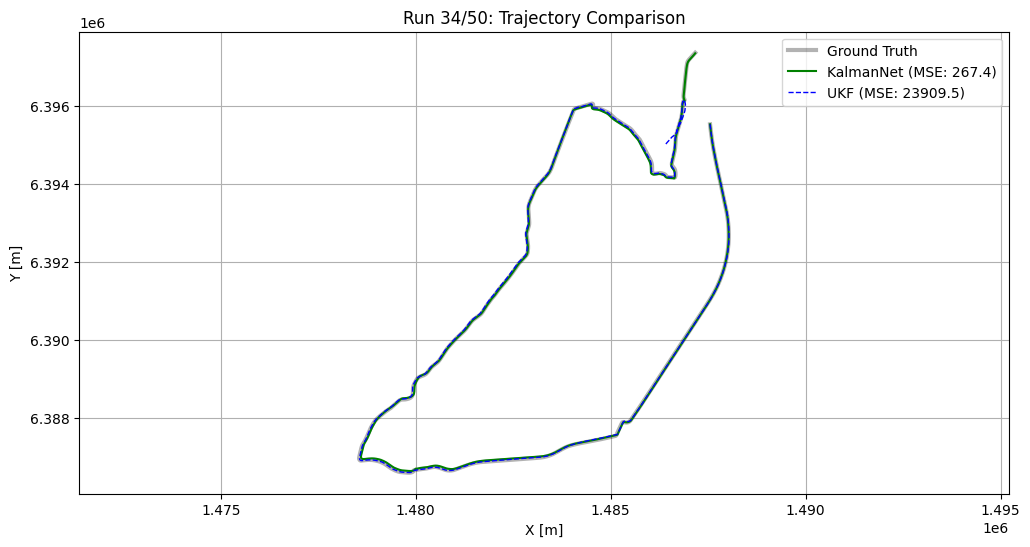

Simulace:  68%|██████▊   | 34/50 [04:11<02:00,  7.56s/it]

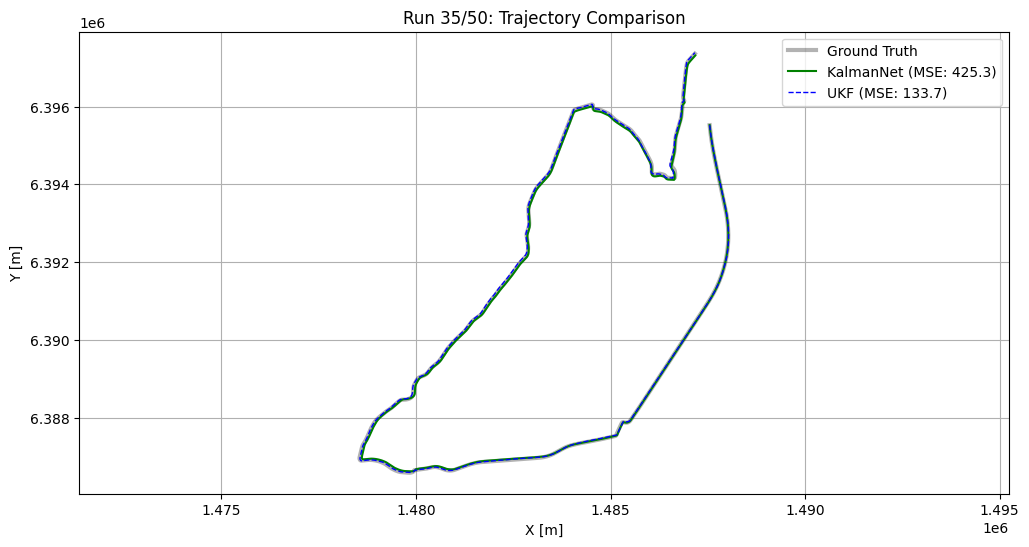

Simulace:  70%|███████   | 35/50 [04:19<01:55,  7.68s/it]

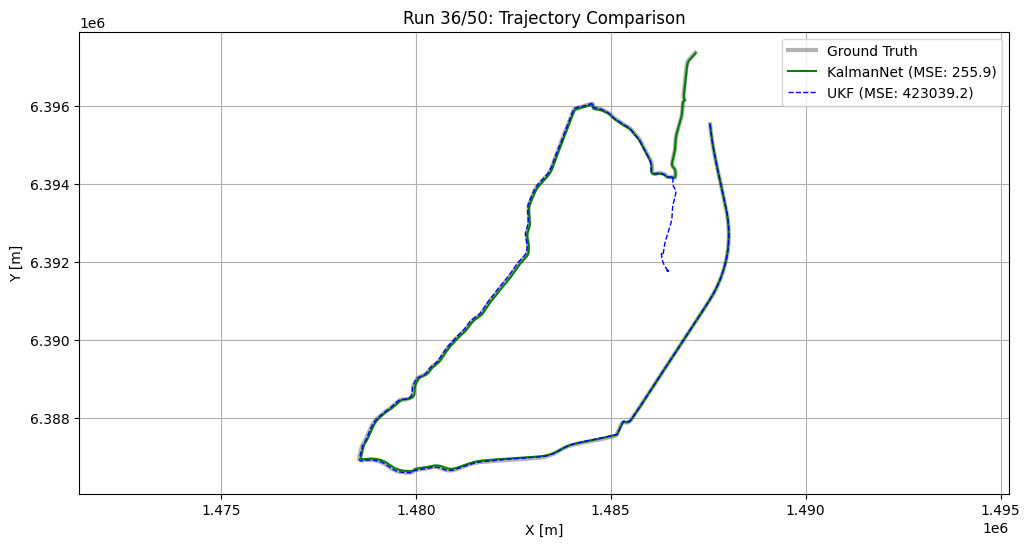

Simulace:  72%|███████▏  | 36/50 [04:26<01:46,  7.64s/it]

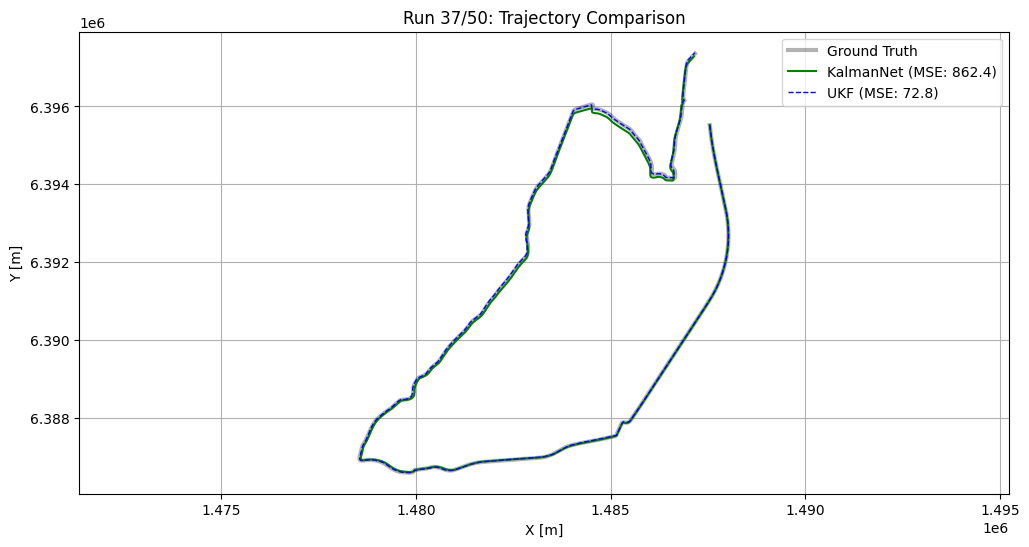

Simulace:  74%|███████▍  | 37/50 [04:34<01:38,  7.61s/it]

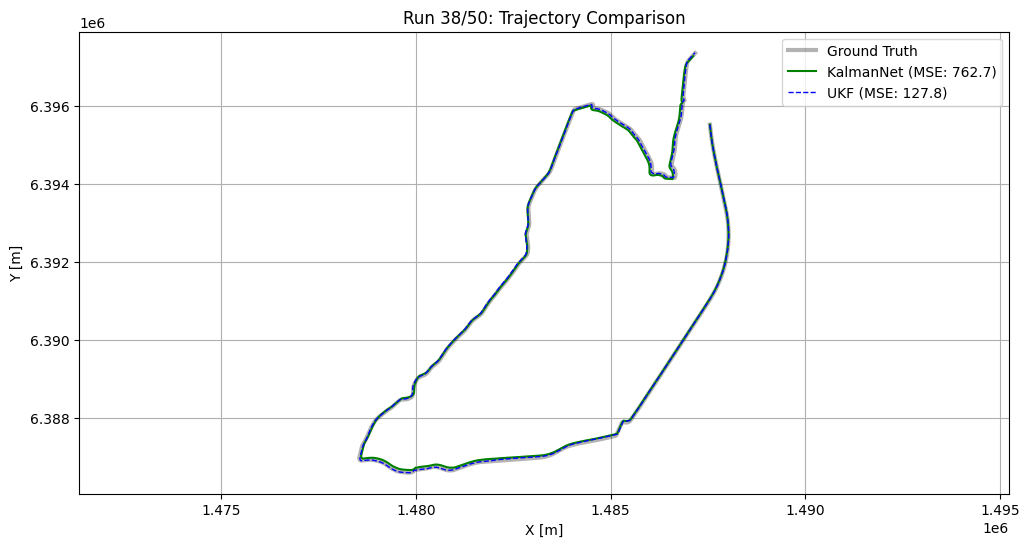

Simulace:  76%|███████▌  | 38/50 [04:42<01:31,  7.59s/it]

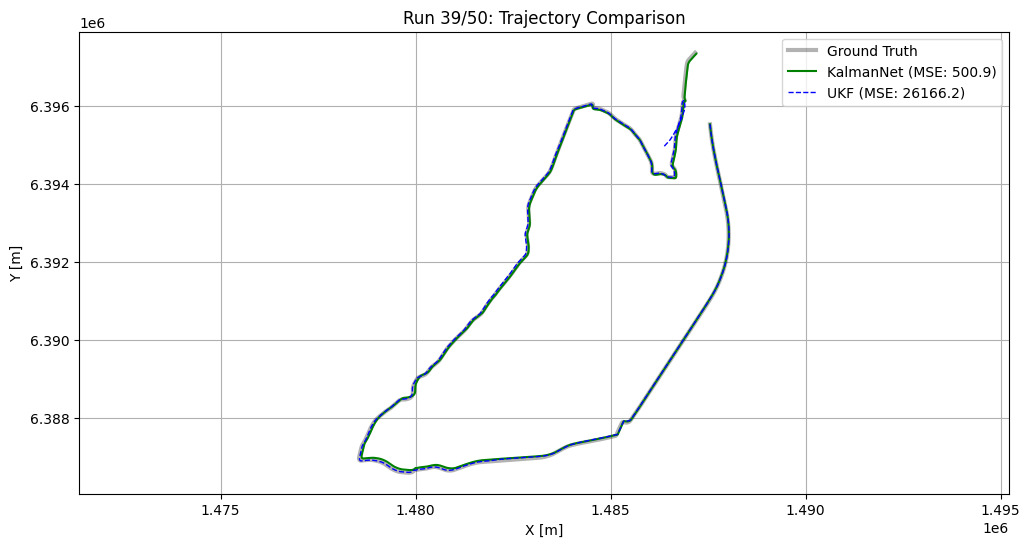

Simulace:  78%|███████▊  | 39/50 [04:49<01:23,  7.59s/it]

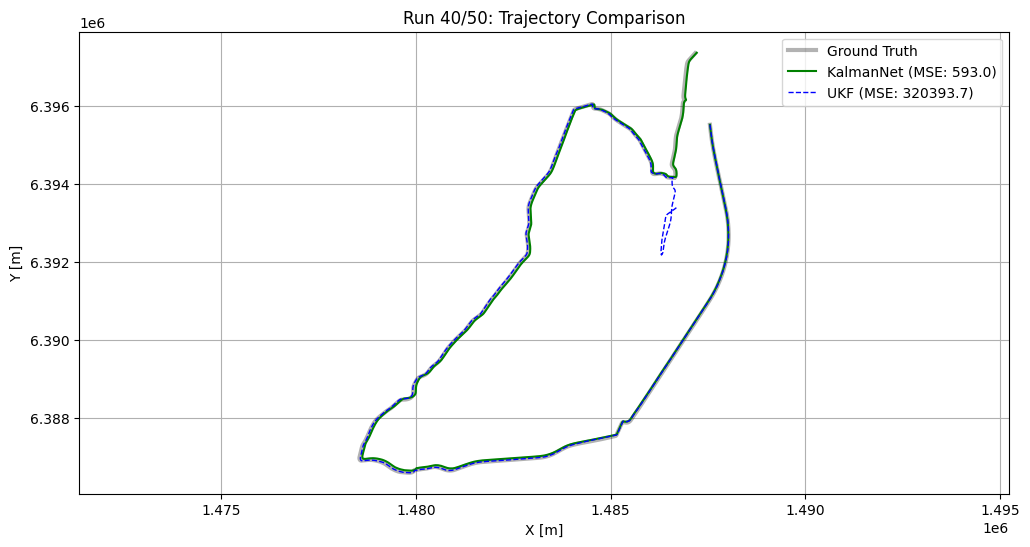

Simulace:  80%|████████  | 40/50 [04:57<01:16,  7.69s/it]

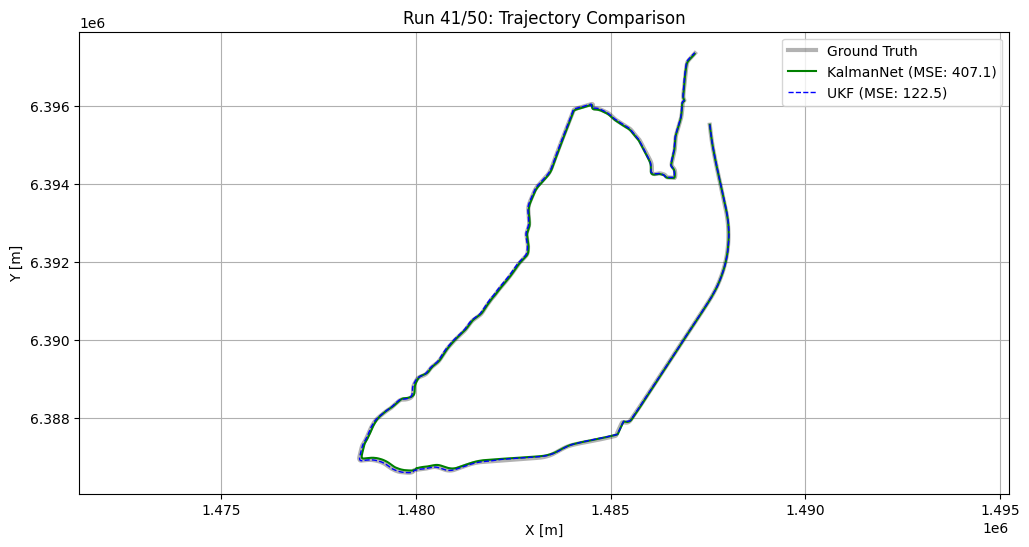

Simulace:  82%|████████▏ | 41/50 [05:05<01:08,  7.63s/it]

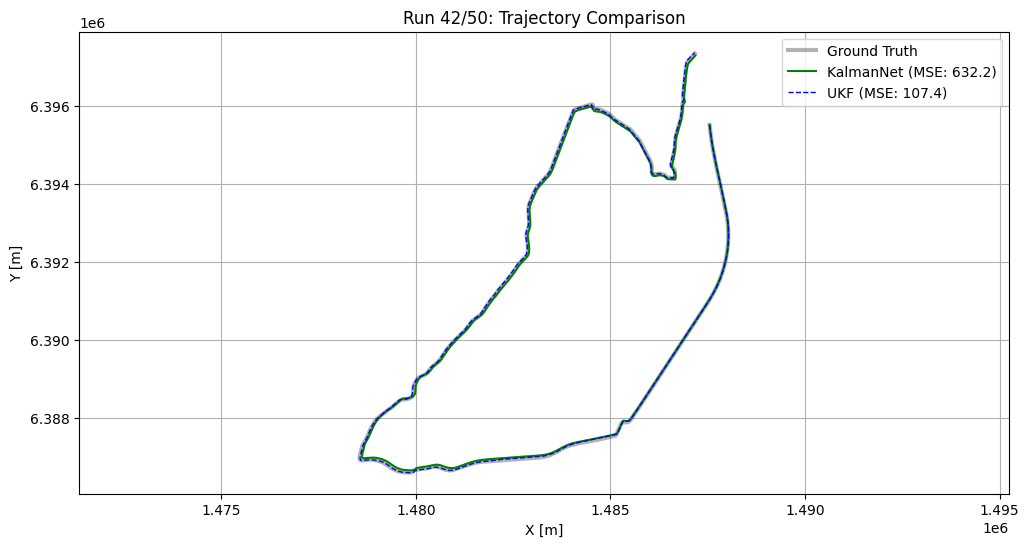

Simulace:  84%|████████▍ | 42/50 [05:12<01:00,  7.51s/it]

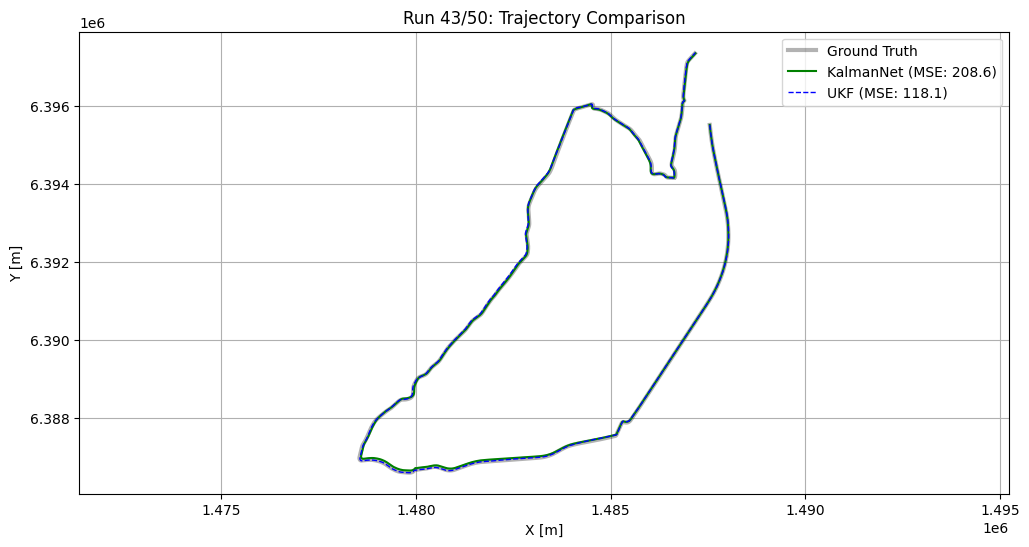

Simulace:  86%|████████▌ | 43/50 [05:19<00:52,  7.46s/it]

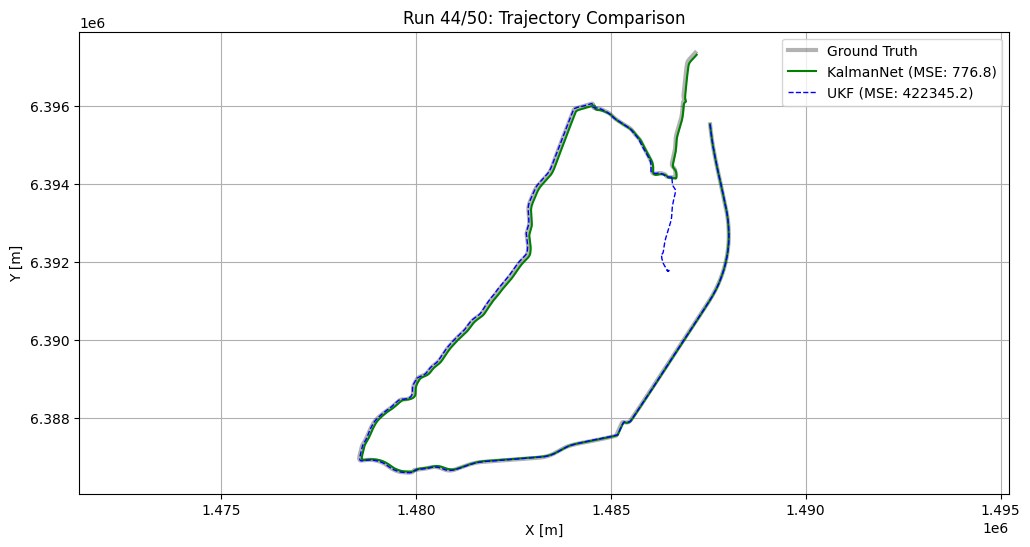

Simulace:  88%|████████▊ | 44/50 [05:27<00:45,  7.50s/it]

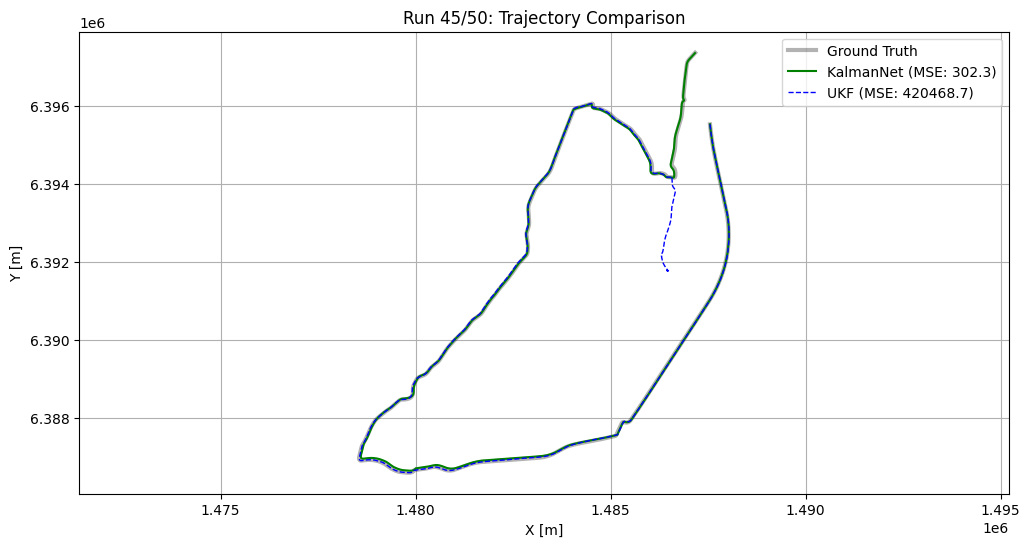

Simulace:  90%|█████████ | 45/50 [05:34<00:37,  7.57s/it]

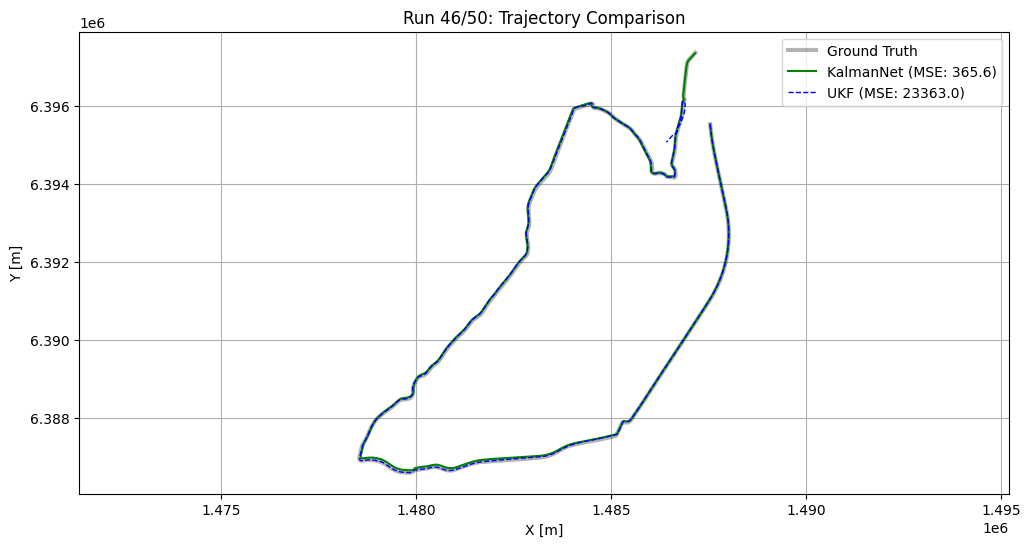

Simulace:  92%|█████████▏| 46/50 [05:43<00:30,  7.75s/it]

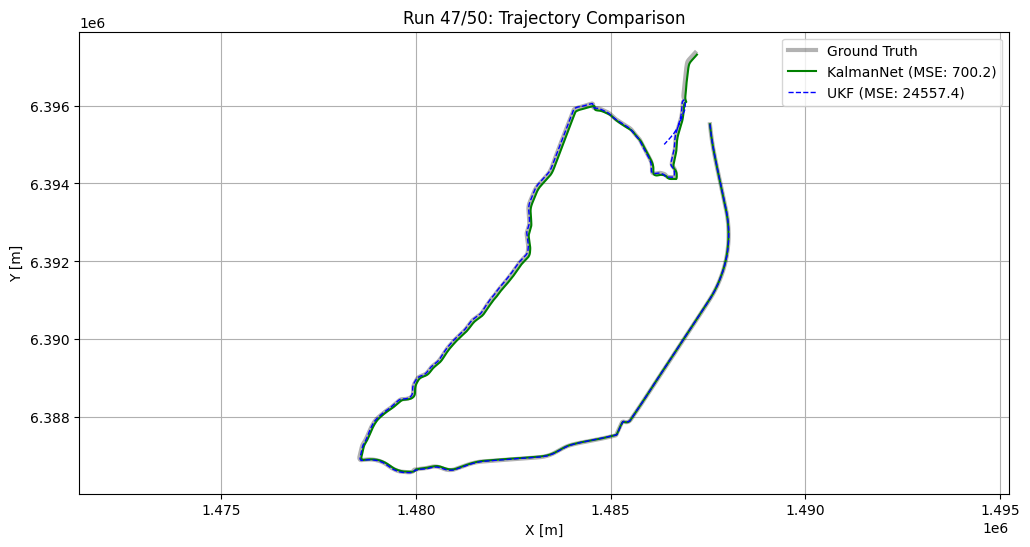

Simulace:  94%|█████████▍| 47/50 [05:50<00:23,  7.71s/it]

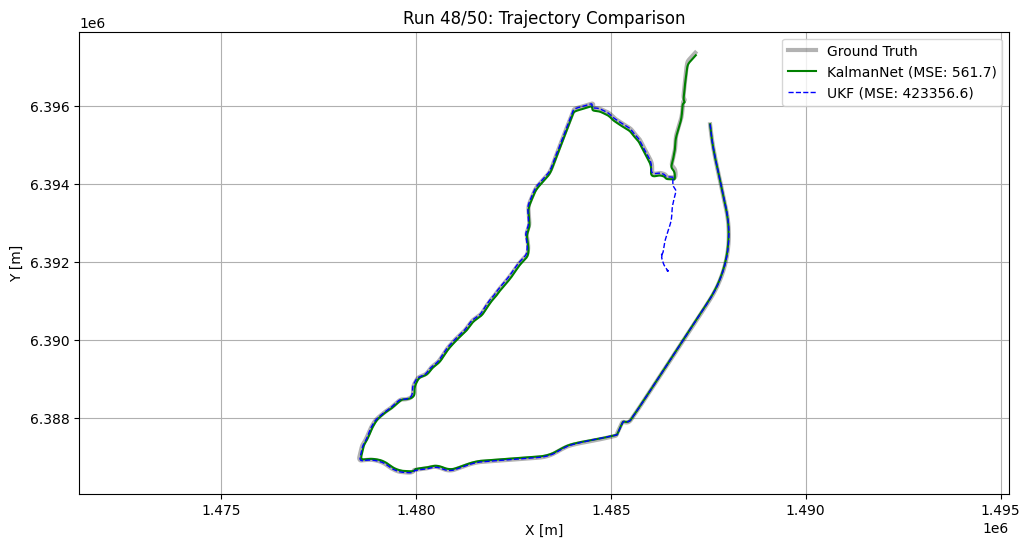

Simulace:  96%|█████████▌| 48/50 [05:58<00:15,  7.60s/it]

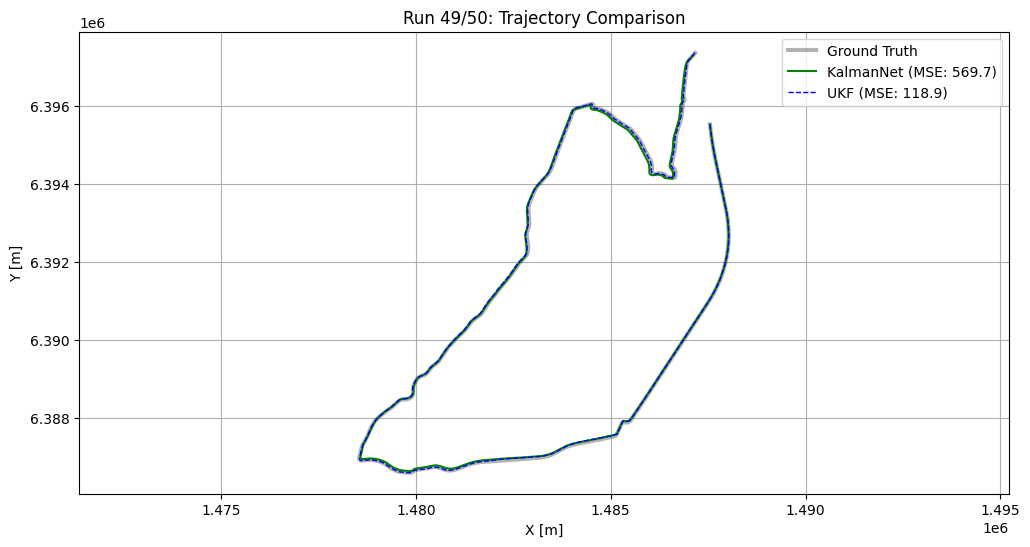

Simulace:  98%|█████████▊| 49/50 [06:05<00:07,  7.51s/it]

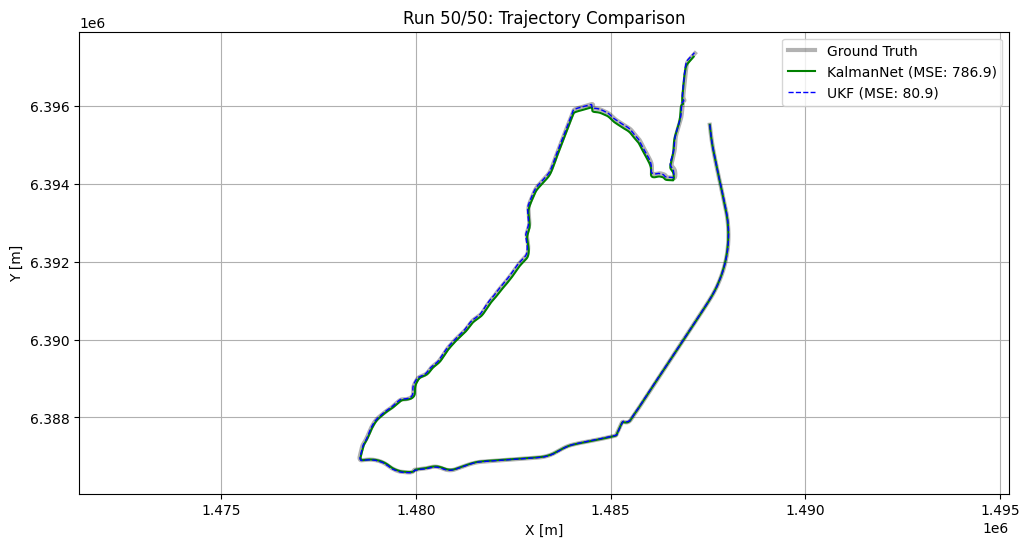

Simulace: 100%|██████████| 50/50 [06:12<00:00,  7.45s/it]


DETAILNÍ VÝSLEDKY PO JEDNOTLIVÝCH BĚZÍCH
    Run_ID  KNet_MSE    UKF_MSE  KNet_PosErr  UKF_PosErr
0        1    775.51 423,075.81        44.76      422.23
1        2    304.09 420,696.66        31.02      423.73
2        3    449.02     424.21        37.80       35.31
3        4    168.38     165.05        23.35       21.56
4        5    353.28      98.14        34.80       18.16
5        6    472.82     177.05        38.20       23.78
6        7    327.28     139.12        32.31       20.39
7        8    587.34 422,688.94        45.37      423.37
8        9    313.19     113.86        32.19       18.04
9       10    341.24     244.07        34.85       28.33
10      11    546.06     138.45        39.34       20.86
11      12    761.96     709.48        51.05       42.36
12      13    683.14 419,251.88        45.18      418.42
13      14    460.75     137.25        37.74       20.42
14      15    312.94      98.59        30.80       17.08
15      16    503.89 419,121.09        39.55  


C:\Users\PC1\AppData\Local\Temp\ipykernel_18872\172183411.py:202: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([agg_pos["KNet"], agg_pos["UKF"]], labels=['KalmanNet', 'UKF'], patch_artist=True)


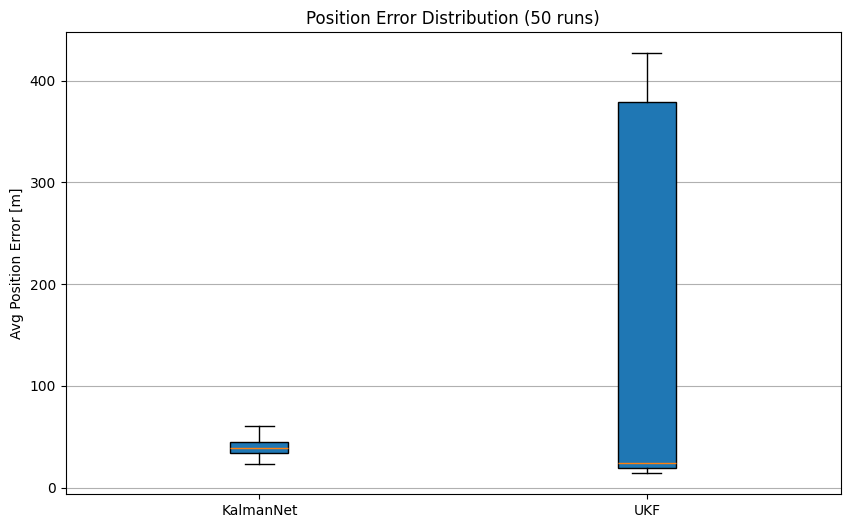

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Pro hezkou tabulku
import Filters
from tqdm import tqdm

import contextlib
import os

real_traj_np = souradniceGNSS[:2, :].T 

real_traj_tensor = torch.from_numpy(real_traj_np).float().to(device)
train_source_tensor = real_traj_tensor[:, :]
# --- POMOCNÁ FUNKCE PRO GENEROWÁNÍ DAT ---
def get_reference_test_set(system, real_traj_tensor, reverse=False):
    
    device = system.Ex0.device
    
    # Předpoklad: mat_data je globální proměnná s načteným .mat souborem
    hB_np = mat_data['hB']
    real_hB_tensor = torch.from_numpy(hB_np).float().to(device).view(-1)

    pos_full = real_traj_tensor.clone().to(device)
    
    deltas = pos_full[1:] - pos_full[:-1] 
    last_vel = deltas[-1:]
    velocities = torch.cat([deltas, last_vel], dim=0) # [T, 2]
    
    x_traj_flat = torch.cat([pos_full, velocities], dim=1) # [T, 4]
    
    # Generování měření (s náhodným šumem uvnitř system.measure)
    y_traj_flat = system.measure(x_traj_flat) # [T, 3]
    
    # Nahrazení barometru reálnými daty (pokud je to žádoucí)
    seq_len = x_traj_flat.shape[0]
    # Pokud chceš simulovat čistě syntetický šum barometru, tento řádek zakomentuj:
    y_traj_flat[:, 0] = real_hB_tensor[:seq_len] 
    
    x_ref = x_traj_flat.unsqueeze(0) # [1, T, 4]
    y_ref = y_traj_flat.unsqueeze(0) # [1, T, 3]
    
    return x_ref, y_ref


# --- KONFIGURACE MC ---
MC_ITERATIONS = 50  # Nastav rozumné číslo (pro 100 grafů by to zahltilo notebook)
PLOT_PER_ITERATION = True # Zda vykreslovat grafy pro každý běh

print(f"=== SPUŠTĚNÍ MONTE CARLO SIMULACE ({MC_ITERATIONS} běhů) ===")
print("Modely: KalmanNet vs. UKF vs. PF")

# 1. Příprava Ground Truth (GT)
real_traj_tensor = torch.from_numpy(real_traj_np).float().to(device)
# Získáme GT stavy (X) jen jednou, protože trajektorie je fixní
# Měření (Y) se bude měnit v každé iteraci kvůli šumu
x_ref_tensor_static, _ = get_reference_test_set(system_model, real_traj_tensor)
x_gt = x_ref_tensor_static.squeeze().cpu().numpy()
seq_len = x_gt.shape[0]

# 2. Inicializace pro sběr dat
detailed_results = [] # Seznam slovníků pro DataFrame
agg_mse = {"KNet": [], "UKF": [], "PF": []}
agg_pos = {"KNet": [], "UKF": [], "PF": []}

# Ujistíme se, že KNet je v eval módu
state_knet2.eval()

# --- HLAVNÍ SMYČKA ---
for i in tqdm(range(MC_ITERATIONS), desc="Simulace"):
    
    # A) Generování nového měření (s novým náhodným šumem)
    # Voláme funkci znovu, abychom dostali Y s jinou realizací šumu (pokud system.measure šumí)
    _, y_ref_tensor = get_reference_test_set(system_model, real_traj_tensor)
    
    # B) Inference: KalmanNet
    with torch.no_grad():
        initial_state = x_ref_tensor_static[:, 0, :] # [1, 4]
        state_knet2.reset(batch_size=1, initial_state=initial_state)
        
        knet_preds = []
        y_input = y_ref_tensor 
        
        for t in range(1, seq_len):
            y_t = y_input[:, t, :]
            x_est = state_knet2.step(y_t)
            knet_preds.append(x_est)
            
        knet_preds_tensor = torch.stack(knet_preds, dim=1)
        full_knet_est = torch.cat([initial_state.unsqueeze(1), knet_preds_tensor], dim=1)
        x_est_knet = full_knet_est.squeeze().cpu().numpy()

    # C) Inference: UKF & PF
    y_for_filters = y_ref_tensor.squeeze(0) 
    
    # !!! KLÍČOVÁ OPRAVA: Použijeme SKUTEČNÝ startovní bod trajektorie !!!
    true_init_state = x_ref_tensor_static[0, 0, :] 
    
    # UKF
    ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
    ukf_res = ukf_ideal.process_sequence(
        y_seq=y_for_filters,
        Ex0=true_init_state, # Správný start
        P0=system_model.P0
    )
    x_est_ukf = ukf_res['x_filtered'].cpu().numpy()

    # PF
    # pf = Filters.ParticleFilter(system_model, num_particles=20000) # Počet částic dle výkonu
    # with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    # # pf = Filters.AuxiliaryParticleFilter(system_model, num_particles=10000) # Počet částic dle výkonu
    #     pf_res = pf.process_sequence(
    #         y_seq=y_for_filters,
    #         Ex0=true_init_state, # Správný start
    #         P0=system_model.P0
    #     )
    # x_est_pf = pf_res['x_filtered'].cpu().numpy()

    
    # D) Výpočet chyb pro tento běh
    # KNet
    diff_knet = x_est_knet - x_gt
    mse_knet = np.mean(diff_knet**2)
    pos_err_knet = np.mean(np.sqrt(diff_knet[:, 0]**2 + diff_knet[:, 1]**2))
    
    # UKF
    diff_ukf = x_est_ukf - x_gt
    mse_ukf = np.mean(diff_ukf**2)
    pos_err_ukf = np.mean(np.sqrt(diff_ukf[:, 0]**2 + diff_ukf[:, 1]**2))
    
    # # PF
    # diff_pf = x_est_pf - x_gt
    # mse_pf = np.mean(diff_pf**2)
    # pos_err_pf = np.mean(np.sqrt(diff_pf[:, 0]**2 + diff_pf[:, 1]**2))
    
    # Uložení do agregátoru
    agg_mse["KNet"].append(mse_knet)
    agg_pos["KNet"].append(pos_err_knet)
    agg_mse["UKF"].append(mse_ukf)
    agg_pos["UKF"].append(pos_err_ukf)
    # agg_mse["PF"].append(mse_pf)
    # agg_pos["PF"].append(pos_err_pf)

    # Uložení do detailního seznamu
    detailed_results.append({
        "Run_ID": i + 1,
        "KNet_MSE": mse_knet,
        "UKF_MSE": mse_ukf,
        "KNet_PosErr": pos_err_knet,
        "UKF_PosErr": pos_err_ukf
    })
    
    # E) Vykreslení grafu pro TENTO běh
    if PLOT_PER_ITERATION:
        fig = plt.figure(figsize=(12, 6))
        plt.plot(x_gt[:, 0], x_gt[:, 1], 'k-', linewidth=3, alpha=0.3, label='Ground Truth')
        
        plt.plot(x_est_knet[:, 0], x_est_knet[:, 1], 'g-', linewidth=1.5, label=f'KalmanNet (MSE: {mse_knet:.1f})')
        plt.plot(x_est_ukf[:, 0], x_est_ukf[:, 1], 'b--', linewidth=1, label=f'UKF (MSE: {mse_ukf:.1f})')
        # plt.plot(x_est_pf[:, 0], x_est_pf[:, 1], 'r:', linewidth=1, alpha=0.8, label=f'PF (MSE: {mse_pf:.1f})')
        
        plt.title(f"Run {i+1}/{MC_ITERATIONS}: Trajectory Comparison")
        plt.xlabel("X [m]")
        plt.ylabel("Y [m]")
        plt.legend()
        plt.axis('equal')
        plt.grid(True)
        plt.show()

# --- VÝPIS VÝSLEDKŮ ---

# 1. Detailní tabulka všech běhů
df_results = pd.DataFrame(detailed_results)
print("\n" + "="*80)
print(f"DETAILNÍ VÝSLEDKY PO JEDNOTLIVÝCH BĚZÍCH")
print("="*80)
# Formátování tabulky pro hezčí výpis
pd.options.display.float_format = '{:,.2f}'.format
print(df_results[["Run_ID", "KNet_MSE", "UKF_MSE", "KNet_PosErr", "UKF_PosErr"]])

# 2. Souhrnná statistika
print("\n" + "="*80)
print(f"SOUHRNNÁ STATISTIKA ({MC_ITERATIONS} běhů)")
print("="*80)

def get_stats(key):
    return np.mean(agg_mse[key]), np.std(agg_mse[key]), np.mean(agg_pos[key]), np.std(agg_pos[key])

knet_stats = get_stats("KNet")
ukf_stats = get_stats("UKF")
# pf_stats = get_stats("PF")

print(f"{'Model':<15} | {'MSE (Mean ± Std)':<25} | {'Pos Error (Mean ± Std)':<25}")
print("-" * 75)
print(f"{'KalmanNet':<15} | {knet_stats[0]:.1f} ± {knet_stats[1]:.1f} | {knet_stats[2]:.2f} ± {knet_stats[3]:.2f} m")
print(f"{'UKF':<15} | {ukf_stats[0]:.1f} ± {ukf_stats[1]:.1f} | {ukf_stats[2]:.2f} ± {ukf_stats[3]:.2f} m")
# print(f"{'PF':<15} | {pf_stats[0]:.1f} ± {pf_stats[1]:.1f} | {pf_stats[2]:.2f} ± {pf_stats[3]:.2f} m")
print("="*80)

# 3. Finální Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([agg_pos["KNet"], agg_pos["UKF"]], labels=['KalmanNet', 'UKF'], patch_artist=True)
plt.title(f"Position Error Distribution ({MC_ITERATIONS} runs)")
plt.ylabel("Avg Position Error [m]")
plt.grid(True, axis='y')
plt.show()

# Test na synteticke trajektorii

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Pro hezkou tabulku
import Filters
from tqdm import tqdm
real_traj_np = souradniceGNSS[:2, :].T 

real_traj_tensor = torch.from_numpy(real_traj_np).float().to(device)
train_source_tensor = real_traj_tensor[:, :]
# --- POMOCNÁ FUNKCE PRO GENEROWÁNÍ DAT ---
def get_reference_test_set(system, real_traj_tensor, reverse=False):
    # Oříznutí trajektorie (pokud je potřeba)
    # real_traj_tensor = real_traj_tensor[:1050,:] 
    
    device = system.Ex0.device
    
    # Předpoklad: mat_data je globální proměnná s načteným .mat souborem
    # hB_np = mat_data['hB']
    # real_hB_tensor = torch.from_numpy(hB_np).float().to(device).view(-1)

    pos_full = real_traj_tensor.clone().to(device)
    
    deltas = pos_full[1:] - pos_full[:-1] 
    last_vel = deltas[-1:]
    velocities = torch.cat([deltas, last_vel], dim=0) # [T, 2]
    
    x_traj_flat = torch.cat([pos_full, velocities], dim=1) # [T, 4]
    
    # Generování měření (s náhodným šumem uvnitř system.measure)
    y_traj_flat = system.measure(x_traj_flat) # [T, 3]
    
    # Nahrazení barometru reálnými daty (pokud je to žádoucí)
    seq_len = x_traj_flat.shape[0]
    # Pokud chceš simulovat čistě syntetický šum barometru, tento řádek zakomentuj:
    # y_traj_flat[:, 0] = real_hB_tensor[:seq_len] 
    
    x_ref = x_traj_flat.unsqueeze(0) # [1, T, 4]
    y_ref = y_traj_flat.unsqueeze(0) # [1, T, 3]
    
    return x_ref, y_ref


# --- KONFIGURACE MC ---
MC_ITERATIONS = 10  # Nastav rozumné číslo (pro 100 grafů by to zahltilo notebook)
PLOT_PER_ITERATION = True # Zda vykreslovat grafy pro každý běh

print(f"=== SPUŠTĚNÍ MONTE CARLO SIMULACE ({MC_ITERATIONS} běhů) ===")
print("Modely: KalmanNet vs. UKF vs. PF")

# 1. Příprava Ground Truth (GT)
real_traj_tensor = torch.from_numpy(real_traj_np).float().to(device)
# Získáme GT stavy (X) jen jednou, protože trajektorie je fixní
# Měření (Y) se bude měnit v každé iteraci kvůli šumu
x_ref_tensor_static, _ = get_reference_test_set(system_model, real_traj_tensor)
x_gt = x_ref_tensor_static.squeeze().cpu().numpy()
seq_len = x_gt.shape[0]

# 2. Inicializace pro sběr dat
detailed_results = [] # Seznam slovníků pro DataFrame
agg_mse = {"KNet": [], "UKF": [], "PF": []}
agg_pos = {"KNet": [], "UKF": [], "PF": []}

# Ujistíme se, že KNet je v eval módu
state_knet2.eval()

# --- HLAVNÍ SMYČKA ---
for i in tqdm(range(MC_ITERATIONS), desc="Simulace"):
    
    # A) Generování nového měření (s novým náhodným šumem)
    # Voláme funkci znovu, abychom dostali Y s jinou realizací šumu (pokud system.measure šumí)
    _, y_ref_tensor = get_reference_test_set(system_model, real_traj_tensor)
    
    # B) Inference: KalmanNet
    with torch.no_grad():
        initial_state = x_ref_tensor_static[:, 0, :] # [1, 4]
        state_knet2.reset(batch_size=1, initial_state=initial_state)
        
        knet_preds = []
        y_input = y_ref_tensor 
        
        for t in range(1, seq_len):
            y_t = y_input[:, t, :]
            x_est = state_knet2.step(y_t)
            knet_preds.append(x_est)
            
        knet_preds_tensor = torch.stack(knet_preds, dim=1)
        full_knet_est = torch.cat([initial_state.unsqueeze(1), knet_preds_tensor], dim=1)
        x_est_knet = full_knet_est.squeeze().cpu().numpy()

    # C) Inference: UKF & PF
    y_for_filters = y_ref_tensor.squeeze(0) 
    
    # !!! KLÍČOVÁ OPRAVA: Použijeme SKUTEČNÝ startovní bod trajektorie !!!
    true_init_state = x_ref_tensor_static[0, 0, :] 
    
    # UKF
    ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
    ukf_res = ukf_ideal.process_sequence(
        y_seq=y_for_filters,
        Ex0=true_init_state, # Správný start
        P0=system_model.P0
    )
    x_est_ukf = ukf_res['x_filtered'].cpu().numpy()

    # PF
    pf = Filters.ParticleFilter(system_model, num_particles=10000) # Počet částic dle výkonu
    pf_res = pf.process_sequence(
        y_seq=y_for_filters,
        Ex0=true_init_state, # Správný start
        P0=system_model.P0
    )
    x_est_pf = pf_res['x_filtered'].cpu().numpy()

    
    # D) Výpočet chyb pro tento běh
    # KNet
    diff_knet = x_est_knet - x_gt
    mse_knet = np.mean(diff_knet**2)
    pos_err_knet = np.mean(np.sqrt(diff_knet[:, 0]**2 + diff_knet[:, 1]**2))
    
    # UKF
    diff_ukf = x_est_ukf - x_gt
    mse_ukf = np.mean(diff_ukf**2)
    pos_err_ukf = np.mean(np.sqrt(diff_ukf[:, 0]**2 + diff_ukf[:, 1]**2))
    
    # PF
    diff_pf = x_est_pf - x_gt
    mse_pf = np.mean(diff_pf**2)
    pos_err_pf = np.mean(np.sqrt(diff_pf[:, 0]**2 + diff_pf[:, 1]**2))
    
    # Uložení do agregátoru
    agg_mse["KNet"].append(mse_knet)
    agg_pos["KNet"].append(pos_err_knet)
    agg_mse["UKF"].append(mse_ukf)
    agg_pos["UKF"].append(pos_err_ukf)
    agg_mse["PF"].append(mse_pf)
    agg_pos["PF"].append(pos_err_pf)

    # Uložení do detailního seznamu
    detailed_results.append({
        "Run_ID": i + 1,
        "KNet_MSE": mse_knet,
        "UKF_MSE": mse_ukf,
        "PF_MSE": mse_pf,
        "KNet_PosErr": pos_err_knet,
        "UKF_PosErr": pos_err_ukf,
        "PF_PosErr": pos_err_pf
    })
    
    # E) Vykreslení grafu pro TENTO běh
    if PLOT_PER_ITERATION:
        fig = plt.figure(figsize=(12, 6))
        plt.plot(x_gt[:, 0], x_gt[:, 1], 'k-', linewidth=3, alpha=0.3, label='Ground Truth')
        
        plt.plot(x_est_knet[:, 0], x_est_knet[:, 1], 'g-', linewidth=1.5, label=f'KalmanNet (MSE: {mse_knet:.1f})')
        plt.plot(x_est_ukf[:, 0], x_est_ukf[:, 1], 'b--', linewidth=1, label=f'UKF (MSE: {mse_ukf:.1f})')
        plt.plot(x_est_pf[:, 0], x_est_pf[:, 1], 'r:', linewidth=1, alpha=0.8, label=f'PF (MSE: {mse_pf:.1f})')
        
        plt.title(f"Run {i+1}/{MC_ITERATIONS}: Trajectory Comparison")
        plt.xlabel("X [m]")
        plt.ylabel("Y [m]")
        plt.legend()
        plt.axis('equal')
        plt.grid(True)
        plt.show()

# --- VÝPIS VÝSLEDKŮ ---

# 1. Detailní tabulka všech běhů
df_results = pd.DataFrame(detailed_results)
print("\n" + "="*80)
print(f"DETAILNÍ VÝSLEDKY PO JEDNOTLIVÝCH BĚZÍCH")
print("="*80)
# Formátování tabulky pro hezčí výpis
pd.options.display.float_format = '{:,.2f}'.format
print(df_results[["Run_ID", "KNet_MSE", "UKF_MSE", "PF_MSE", "KNet_PosErr", "UKF_PosErr", "PF_PosErr"]])

# 2. Souhrnná statistika
print("\n" + "="*80)
print(f"SOUHRNNÁ STATISTIKA ({MC_ITERATIONS} běhů)")
print("="*80)

def get_stats(key):
    return np.mean(agg_mse[key]), np.std(agg_mse[key]), np.mean(agg_pos[key]), np.std(agg_pos[key])

knet_stats = get_stats("KNet")
ukf_stats = get_stats("UKF")
pf_stats = get_stats("PF")

print(f"{'Model':<15} | {'MSE (Mean ± Std)':<25} | {'Pos Error (Mean ± Std)':<25}")
print("-" * 75)
print(f"{'KalmanNet':<15} | {knet_stats[0]:.1f} ± {knet_stats[1]:.1f} | {knet_stats[2]:.2f} ± {knet_stats[3]:.2f} m")
print(f"{'UKF':<15} | {ukf_stats[0]:.1f} ± {ukf_stats[1]:.1f} | {ukf_stats[2]:.2f} ± {ukf_stats[3]:.2f} m")
print(f"{'PF':<15} | {pf_stats[0]:.1f} ± {pf_stats[1]:.1f} | {pf_stats[2]:.2f} ± {pf_stats[3]:.2f} m")
print("="*80)

# 3. Finální Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([agg_pos["KNet"], agg_pos["UKF"], agg_pos["PF"]], labels=['KalmanNet', 'UKF', 'PF'], patch_artist=True)
plt.title(f"Position Error Distribution ({MC_ITERATIONS} runs)")
plt.ylabel("Avg Position Error [m]")
plt.grid(True, axis='y')
plt.show()